<a href="https://colab.research.google.com/github/eflatlan/CNN_PID/blob/models_sacved/Segmentation_HMPID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install h5py numpy

import os
import h5py
import numpy as np

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/dev_floatmap/helper_functions.py
#from helper_functions.py import print_points, plot_mapsm

In [3]:





!wget -O ParticleDataUtilsCp.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/ParticleDataUtils36.py
from ParticleDataUtilsCp import ParticleDataUtils, classify_candidates_with_pad_sequences

!wget -O misc_helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions2.py
from misc_helper_functions import build_species_layers, calculate_theta, filter_data, create_lr_scheduler,plot_lr, extract_neighborhood_map, create_cnn_model # plot_worst

# !wget -O helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
# !wget -O plot_helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions17.py

# import plot_helper_functions


# from plot_helper_functions import plot_hist

# from plot_helper_functions import plot_training_history
#from plot_helper_functions import plot_training_history#, plot_dist2mip_histograms, plot_maps


print(classify_candidates_with_pad_sequences)


--2023-09-26 21:12:54--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/ParticleDataUtils36.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21728 (21K) [text/plain]
Saving to: ‘ParticleDataUtilsCp.py’

ParticleDataUtilsCp 100%[===================>]  21.22K  --.-KB/s    in 0.002s  

2023-09-26 21:12:54 (12.1 MB/s) - ‘ParticleDataUtilsCp.py’ saved [21728/21728]

1000
--2023-09-26 21:12:58--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response..

In [4]:



from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

import numpy as np
MASS_PION = 0.1396
MASS_KAON = 0.4937
MASS_PROTON = 0.938

# Squared masses
MASS_PION_SQ = MASS_PION * MASS_PION
MASS_KAON_SQ = MASS_KAON * MASS_KAON
MASS_PROTON_SQ = MASS_PROTON * MASS_PROTON
REF_INDEX_FREON = 1.29  # Given refraction index
REF_INDEX_FREON_SQ = REF_INDEX_FREON * REF_INDEX_FREON

def threshold_momentum(pdg_code, p):
	"""
	Calculate the threshold momentum based on the given PDG code.

	:param pdg_code: PDG code of the particle.
	p : momentum of track
	(tbd : refindex)

	:return : boolean value for Cherenkov radiation.
	"""

	# Determine mass based on PDG code
	if abs(pdg_code) == 211:
		mass = MASS_PION
	elif abs(pdg_code) == 321:
		mass = MASS_KAON
	elif abs(pdg_code) == 2212:
		mass = MASS_PROTON
	else:
		raise ValueError(f"Unsupported PDG code: {pdg_code}")

	p_lim = mass/(np.sqrt(REF_INDEX_FREON_SQ-1))
	print(f" p_lim {p_lim} p {p}")
	return p_lim < p



def pad_and_stack(sequences, max_length=None):
	# Your existing code
	try:
		# Try padding, if max_length is not None, pad or truncate to that length
		padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', dtype='float32')  # Changed dtype to 'floar32'
	except ValueError:
		# Fallback: manually pad with zeros
		max_len = max_length if max_length is not None else max(len(seq) for seq in sequences)
		padded_sequences = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=0) for seq in sequences])

	return padded_sequences




import numpy as np
import numpy as np

def classify_candidates_with_pad_sequences(x_values_data, y_values_data, q_values_data, mCluSize_lista, candStatus_values_data, max_length_nested, xmip_list, ymip_list):

	# Ensure x_values_data has the right dimension
	if np.ndim(x_values_data) == 1:
		x_values_data = np.expand_dims(x_values_data, axis=-1)

	# Pad the sequences
	x_padded = pad_and_stack(x_values_data, max_length=max_length_nested)
	y_padded = pad_and_stack(y_values_data, max_length=max_length_nested)
	q_padded = pad_and_stack(q_values_data, max_length=max_length_nested)
	size_padded = pad_and_stack(mCluSize_lista, max_length=max_length_nested)
	candStatus_padded = pad_and_stack(candStatus_values_data, max_length=max_length_nested).astype(int)

	# Modify candStatus based on charge and size threshold
	candStatus_padded[(q_padded >= 150) & (size_padded >= 3)] = 1
	# candStatus_padded[outside_fiducial_zones] = 0

	# Define masks for different particle statuses
	proton_values = [2, 4, 6, 8]
	kaon_values = [3, 4, 7, 8] # 3,5,7,8 ??
	pion_values = [5, 6, 7, 8]

	proton_mask = np.isin(candStatus_padded, proton_values)
	kaon_mask = np.isin(candStatus_padded, kaon_values)
	pion_mask = np.isin(candStatus_padded, pion_values)

	# Stack the data into a single array
	padded_data = np.stack([x_padded, y_padded, q_padded, size_padded], axis=-1)

	# Create masks for positive and non statuses
	positive_mask = (candStatus_padded > 0).astype(bool)
	non_mask = (candStatus_padded <= 1).astype(bool)

	# Populate particle candidates arrays
	pion_candidates = np.zeros_like(padded_data)
	kaon_candidates = np.zeros_like(padded_data)
	proton_candidates = np.zeros_like(padded_data)
	non_candidates = np.zeros_like(padded_data)
	pion_candidates[positive_mask & pion_mask] = padded_data[positive_mask & pion_mask]
	kaon_candidates[positive_mask & kaon_mask] = padded_data[positive_mask & kaon_mask]
	proton_candidates[positive_mask & proton_mask] = padded_data[positive_mask & proton_mask]
	non_candidates[non_mask] = padded_data[non_mask]

	return pion_candidates, kaon_candidates, proton_candidates, non_candidates, candStatus_padded

import random


from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

import sys

print(sys.getrecursionlimit()) # Prints 1000

print_vals = False
from numpy.linalg import norm
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_curve, confusion_matrix

from scipy.signal import find_peaks

import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, Lambda, Flatten, Dense, concatenate, BatchNormalization, MaxPooling2D, Dropout, LeakyReLU, Masking, Embedding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import EarlyStopping

# create a callback
early_stopping = EarlyStopping(
	monitor='val_loss', # you can monitor 'val_loss' or 'val_accuracy'
	patience=100, # stop training if the monitored quantity does not improve for 50 epochs
	restore_best_weights=True, # restore model weights from the epoch with the best value
)

class Constants:
	PION_MASS = 0.1396
	KAON_MASS = 0.4937
	PROTON_MASS = 0.938

np.set_printoptions(precision=4)

@staticmethod
def calculate_mass(momentum, refractiveIndex, ckov):
	""" args : momentum, refractiveIndex, ckov
		returns : mass
	"""
	mass = momentum * np.sqrt((refractiveIndex * np.cos(ckov))**2 - 1)
	return mass


class ParticleDataUtils:

	def __init__(self, filenames =  [], percentage_to_read = 100):
		self.filename = filenames
		self.percentage_to_read = percentage_to_read
		self.particle_vector = []
		self.load_data(filenames=filenames)

		#
		# jeg flyttet
		self.particle_info = self.process_data(self.particle_vector, self.percentage_to_read)
		self.num_particles = len(self.particle_info)


		# new scalers to be created :
		self.phi_scaler, self.phi_stats = self.create_scalar_scaler("phiP")
		self.theta_scaler, self.theta_stats = self.create_scalar_scaler("thetaP")
		self.refractive_index_scaler, self.refractive_index_stats = self.create_scalar_scaler("refractiveIndex")
		self.momentum_scaler, self.momentum_stats = self.create_scalar_scaler("momentum")
		self.mCluSize_scaler, self.mCluSize_stats = self.create_scalar_scaler("mCluSize")
		self.mCluCharge_scaler, self.mCluCharge_stats = self.create_scalar_scaler("mCluCharge")
		print("Created scaler for scalars")

		# 2D
		self.mip_scaler, self.mip_stats = self.create_2D_scaler("mip_position")
		self.rad_scaler, self.rad_stats = self.create_2D_scaler("rad_position")

		# # vector of 2D
		self.proton_scalers, self.proton_stats = self.create_vector_scaler("proton_candidates")
		self.kaon_scalers, self.kaon_stats = self.create_vector_scaler("kaon_candidates")
		self.pion_scalers, self.pion_stats = self.create_vector_scaler("pion_candidates")



		#self.ckov_scaler, self.ckov_stats = self.create_scaler("ckov")
		#self.distances_scaler, self.distances_stats = self.create_scaler("distances")def classify_candidates(candidates_data):


	class Candidate2:
		def __init__(self, x_values, y_values, chi2_values, q_values, xe_values, ye_values, candStatus_values):
			self.x_values = x_values
			self.y_values = y_values
			self.chi2_values = chi2_values
			self.q_values = q_values
			self.xe_values = xe_values
			self.ye_values = ye_values
			self.candStatus_values = candStatus_values


	class ParticleInfo: # p
		def __init__(self,  momentum, refractiveIndex, xRad, yRad, xMIP, yMIP, thetaP, phiP, mCluCharge, mCluSize, non_candidates, pion_candidates, kaon_candidates, proton_candidates, mTrackPdg, index, pion_flag, kaon_flag, proton_flag):
			self.momentum = momentum # this dhould be with
			self.refractiveIndex = refractiveIndex # with
			self.xRad = xRad # with
			self.yRad = yRad # with

			self.xMIP = xMIP # with
			self.yMIP = yMIP # with

			self.mCluCharge = mCluCharge # with
			self.mCluSize = mCluSize # with

			self.thetaP = thetaP# with
			self.phiP = phiP# with
			self.non_candidates = non_candidates # with the field candStatus is a int that is 0..7, please make it categorical
			self.rad_position = [xRad, yRad]
			self.mip_position = [xMIP, yMIP]


			self.pion_candidates = pion_candidates # pion_candidates = [1 if (int(candStatus) & 4) == 4 else 0 for candStatus in candsCombined]
			self.kaon_candidates = kaon_candidates # = kaon_candidates [1 if (int(candStatus) & 2) == 2 else 0 for candStatus in candsCombined]
			self.proton_candidates = proton_candidates # = proton_candidates[1 if (int(candStatus) & 1) == 1 else 0 for candStatus in candsCombined]


			self.pion_flag = pion_flag # pion_candidates = [1 if (int(candStatus) & 4) == 4 else 0 for candStatus in candsCombined]
			self.kaon_flag = kaon_flag # = kaon_candidates [1 if (int(candStatus) & 2) == 2 else 0 for candStatus in candsCombined]
			self.proton_flag = proton_flag # = proton_candidates[1 if (int(candStatus) & 1) == 1 else 0 for candStatus in candsCombined]

			self.mTrackPdg = mTrackPdg # with
			self.index_particle = index # with

			abs_mTrackPdg = abs(self.mTrackPdg)  # Take the absolute value

			# Set particleType based on absolute PDG code
			if abs_mTrackPdg == 211:
				self.particleType = 'pion'
			elif abs_mTrackPdg == 321:
				self.particleType = 'kaon'
			elif abs_mTrackPdg == 2212:
				self.particleType = 'proton'
			else:
				self.particleType = 'other'
				#print(f"pdg type was other : {abs_mTrackPdg}")


		@staticmethod
		def infer_mass_category_from_ckov(momentum, refractiveIndex, ckov):
			mass = momentum * np.sqrt((refractiveIndex * np.cos(ckov))**2 - 1)

			mass_category = "unknown"
			if abs(mass - Constants.PION_MASS) < 1e-4:
				mass_category = "pion"
			elif abs(mass - Constants.KAON_MASS) < 1e-4:
				mass_category = "kaon"
			elif abs(mass - Constants.PROTON_MASS) < 1e-4:
				mass_category = "proton"
			if print_vals:
			  print(f"\ninfer_mass_category_from_ckov :  momentum = {momentum}|  mass_calc = {mass} |  mass_category={mass_category} | refractiveIndex = {refractiveIndex} | ckov = {ckov}")
			return mass_category

		@staticmethod
		def infer_mass_category(mass):
			if abs(mass - Constants.PION_MASS) < 1e-6:
				return "pion"
			elif abs(mass - Constants.KAON_MASS) < 1e-6:
				return "kaon"
			elif abs(mass - Constants.PROTON_MASS) < 1e-6:
				return "proton"
			else:
				return "unknown"

		def __str__(self):
			if print_vals:
			  return (f"ParticleInfo(momentum={self.momentum} | mass={self.mass} |  mass_category={self.mass_category} | "
					  f"refractiveIndex={self.refractiveIndex} | ckov={self.ckov} | rad_position={len(self.rad_position)}, "
					  f"mip_position={self.mip_position})")

	#  ''' def calculate_distances_to_mip(self):
	#       """Calculate Euclidean distances from all filled bins to MIP position"""
	#       filledBins_np = np.array(self.filledBins)
	#       mip_position_np = np.array(self.mip_position)

	#       distances = np.linalg.norm(filledBins_np - mip_position_np, axis=1)
	#       return distances'''


	def load_data(self, filenames):
		drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'

		max_length_nested = 0
		num_particles = 0
		file_num = 0
		for filename in filenames:
			file_path = os.path.join(drive_path, filename)
			print(f"Reading file {file_num} : {filename}")
			with h5py.File(file_path, 'r') as file:
				for i, group_name in enumerate(file):
					group = file[group_name]
					num_particles = num_particles + 1
					current_length = len(group['ye_values'][...])
					if current_length > max_length_nested:
						max_length_nested = current_length
						print(f" i {i} max_length_nested {max_length_nested}")


		# Lists to store scalar and array-like attributes
		momentum_list = np.zeros((num_particles, 1))
		refractiveIndex_list = np.zeros((num_particles, 1))
		xRad_list = np.zeros((num_particles, 1))
		yRad_list = np.zeros((num_particles, 1))
		xMIP_list = np.zeros((num_particles, 1))
		yMIP_list = np.zeros((num_particles, 1))
		thetaP_list = np.zeros((num_particles, 1))
		phiP_list = np.zeros((num_particles, 1))
		mCluCharge_list = np.zeros((num_particles, 1))
		mCluSize_list = np.zeros((num_particles, 1))
		mTrackPdg_list = np.zeros((num_particles, 1))


		x_values_data_list = np.zeros((num_particles, max_length_nested))
		y_values_data_list =  np.zeros((num_particles, max_length_nested))
		chi2_values_data_list =  np.zeros((num_particles, max_length_nested))
		q_values_data_list =  np.zeros((num_particles, max_length_nested))
		xe_values_data_list =  np.zeros((num_particles, max_length_nested))
		ye_values_data_list =  np.zeros((num_particles, max_length_nested))
		candStatus_values_data_list =  np.zeros((num_particles, max_length_nested))
		size_clu_lst =  np.zeros((num_particles, max_length_nested))


		index_particle = 0
		for filename in filenames:
			file_path = os.path.join(drive_path, filename)
			print(f"Reading file {file_num} : {filename}")
			with h5py.File(file_path, 'r') as file:
				for i, group_name in enumerate(file):
					group = file[group_name]

					# Store scalar attributes into lists
					momentum_list[index_particle] = group.attrs['Momentum']
					refractiveIndex_list[index_particle] = group.attrs['RefractiveIndex']
					xRad_list[index_particle] = group.attrs['xRad']
					yRad_list[index_particle] = group.attrs['yRad']
					xMIP_list[index_particle] = group.attrs['xMip']
					yMIP_list[index_particle] = group.attrs['yMip']
					thetaP_list[index_particle] = group.attrs['ThetaP']
					phiP_list[index_particle] = group.attrs['PhiP']
					mCluCharge_list[index_particle] = group.attrs['CluCharge']
					mCluSize_list[index_particle] = group.attrs['CluSize']
					mTrackPdg_list[index_particle] = group.attrs['TrackPdg']

					actual_length = len(group['x_values'][...])
					x_values_data_list[index_particle, :actual_length] = group['x_values'][...]

					actual_length = len(group['y_values'][...])
					y_values_data_list[index_particle, :actual_length] = group['y_values'][...]

					actual_length = len(group['chi2_values'][...])
					chi2_values_data_list[index_particle, :actual_length] = group['chi2_values'][...]

					actual_length = len(group['q_values'][...])
					q_values_data_list[index_particle, :actual_length] = group['q_values'][...]

					actual_length = len(group['xe_values'][...])
					xe_values_data_list[index_particle, :actual_length] = group['xe_values'][...]

					actual_length = len(group['ye_values'][...])
					ye_values_data_list[index_particle, :actual_length] = group['ye_values'][...]

					actual_length = len(group['candStatus_values'][...])
					candStatus_values_data_list[index_particle, :actual_length] = group['candStatus_values'][...]


					actual_length = len(group['mSize_values'][...])
					size_clu_lst[index_particle, :actual_length] = group['mSize_values'][...]

					index_particle += 1

					# cehck the length of current entry inn   ye_values_data_list and update max_length_nested if logner
					current_length = len(group['ye_values'][...])
					#print(f" i {i} appending")

					if current_length > max_length_nested:
						max_length_nested = current_length
						print(f" i {i} max_length_nested {max_length_nested}")



		pion_candidates, kaon_candidates, proton_candidates, non_candidates, cand_combined = classify_candidates_with_pad_sequences(
			x_values_data_list, y_values_data_list, size_clu_lst,
			q_values_data_list, candStatus_values_data_list,
			max_length_nested,xMIP_list, yMIP_list
	  	)

		print(f"pion_candidates shape {pion_candidates.shape}")
		print(f"Dtype pion_candidates : {pion_candidates.dtype}")  # Output will be something like: int64
		print(f"Dtype momentum_list : {momentum_list.dtype}")  # Output will be something like: int64

		print(f"momentum_list shape {momentum_list.shape}")

		particle_vector = [None] * len(momentum_list)

		MIP_list = np.hstack([xMIP_list, yMIP_list])

		# Reshape the array to (N, 1, 2)
		MIP_list_reshaped = MIP_list[:, np.newaxis, :]

		# Extract only the x and y coordinates from pion_candidates
		pion_candidates_xy = pion_candidates[:, :, :2]

		# Compute squared differences
		diff = np.sum((pion_candidates_xy - MIP_list_reshaped)**2, axis=2)
		r_max = 35
		r_min = 0.5
		# Count the number of points within radius r (5 to 40)
		non_padded_mask = np.any(pion_candidates[:, :, :2] != 0, axis=2)
		within_r_mask = (diff >= r_min**2) & (diff <= r_max**2) & non_padded_mask

		count_within_r = np.sum(within_r_mask, axis=1)

		print(f"momentum_list shape {np.array(momentum_list).shape}")
		print(f"pion_candidates[i] shape {pion_candidates.shape}")
		print(f"Dtype : {pion_candidates.dtype}")  # Output will be something like: int64
		print(f"Dtype : {pion_candidates.dtype}")  # Output will be something like: int64



		tGap = 8.0
		rW = 1.5
		qW = 0.5
		L = rW / 2



		# Calculate L, dy, dx, X, Y, and dist
		L = (rW - L + tGap + qW) * np.tan(thetaP_list)
		dy = L * np.sin(phiP_list)
		dx = L * np.cos(phiP_list)
		X = xRad_list + dx
		Y = yRad_list + dy
		dist = np.sqrt((xMIP_list - X)**2 + (yMIP_list - Y)**2)


		for i in range(len(momentum_list)):


			print(f"p { momentum_list[i]} pdg {mTrackPdg_list[i]}")

			abs_pdg = abs(mTrackPdg_list[i])


			if abs_pdg in [211, 321, 2212]:
				print(f"p { momentum_list[i]} pdg {abs_pdg}")

				# check if exceeds momentum limit for ckov photons
				if threshold_momentum(abs_pdg, momentum_list[i]):
					num_pions = np.count_nonzero(pion_candidates[i])
					num_kaons = np.count_nonzero(kaon_candidates[i])
					num_protons = np.count_nonzero(proton_candidates[i])

					if abs_pdg == 211: non_zero_val =  num_pions
					if abs_pdg == 321: non_zero_val = num_kaons
					if abs_pdg == 2212: non_zero_val =  num_protons



					# TODO : do flags on momentum
					# penalty on number of photons ?

					pion_flag = (num_pions < 6*4) | (~threshold_momentum(211, momentum_list[i]))
					kaon_flag = (num_kaons < 5*4) | (~threshold_momentum(321, momentum_list[i]))
					proton_flag = (num_protons < 4*4) | (~threshold_momentum(2212, momentum_list[i]))


					print(f"non_zero_val {non_zero_val}")
					# Check if any candidate has more than 5 non-zero values

					if non_zero_val > 20 and dist[i] < 0.2:
							particle_info = ParticleDataUtils.ParticleInfo(
									momentum_list[i], refractiveIndex_list[i], xRad_list[i], yRad_list[i],
									xMIP_list[i], yMIP_list[i], thetaP_list[i], phiP_list[i],
									mCluCharge_list[i], mCluSize_list[i], non_candidates[i], pion_candidates[i],
									kaon_candidates[i], proton_candidates[i], mTrackPdg_list[i],
									i, pion_flag, kaon_flag, proton_flag
							)
							particle_vector[i] = particle_info
							self.particle_vector.append(particle_info)
					else :
							print(f" dist to long {dist[i]}")


	def process_data(self, particle_vector, percentage):

		# Calculate the number of particles based on the percentage
		num_particles = int(len(self.particle_vector) * (percentage / 100.0))
		# Slice the particle_vector to the desired percentage
		particle_vector = self.particle_vector[:num_particles]
		return particle_vector

	def create_scalar_scaler(self, feature):
		try:
				if feature in ["momentum", "refractiveIndex", "phiP", "thetaP", "mCluSize", "mCluCharge"]:  # added mCluSize and mCluCharge
					values = np.array([getattr(info, feature) for info in self.particle_info]).reshape(-1, 1)
					if values.size == 0:
						raise ValueError(f"Empty values array for feature: {feature}")
					scaler = StandardScaler()
					scaled_values = scaler.fit_transform(values)
					values = scaled_values

					stats = {
						"mean": scaler.mean_[0],
						"std": scaler.scale_[0]
					}
					return scaler, stats
				else:
					raise ValueError(f"Invalid feature: {feature}")

		except Exception as e:
				print(f"An error occurred in create_scalar_scaler: {e}")
				raise



	def create_2D_scaler(self, feature):
		try:
				if feature in ["mip_position", "rad_position"]:
						values = np.array([getattr(info, feature) for info in self.particle_info])
				if values.size == 0:
						raise ValueError(f"Empty values array for feature: {feature}")

				scaler_x = StandardScaler()
				scaler_y = StandardScaler()



				print(f"create_2D_scalervalues.shape : {values.shape}")

				n_samples, dim, r = values.shape
				print(f"create_2D_scalervalues.shape : {values[:, 0].shape}")

				feature_values_x = values[:, 0].reshape(n_samples, 1)
				scaled_values_x = scaler_x.fit_transform(feature_values_x).reshape(n_samples, 1)
				values[:, 0] = scaled_values_x

				feature_values_y = values[:, 1].reshape(n_samples, 1)
				scaled_values_y = scaler_y.fit_transform(feature_values_y).reshape(n_samples, 1)
				values[:, 1] = scaled_values_y


				# Store both the scalers
				scalers = {'x': scaler_x, 'y': scaler_y}
				stats = {
				'x': {
				"mean": scaler_x.mean_[0],
				"std": scaler_x.scale_[0]
				},
				'y': {
					"mean": scaler_y.mean_[0],
					"std": scaler_y.scale_[0]
					}
				}
				return scalers, stats
		except Exception as e:
			print(f"An error occurred in create_2D_scaler: {e}")
			raise

	def create_vector_scaler(self, feature):
		try:
			if feature in ["pion_candidates", "kaon_candidates", "proton_candidates"]:
				values = np.array([getattr(info, feature) for info in self.particle_info])
				if values.size == 0:
						raise ValueError(f"Empty values array for feature: {feature}")

				n_samples, n_clusters, n_features = values.shape
				scalers = []

				for i in range(n_features):
					scaler = StandardScaler()
					feature_values = values[:, :, i].reshape(-1, 1)
					scaled_values = scaler.fit_transform(feature_values).reshape(n_samples, n_clusters)
					values[:, :, i] = scaled_values
					scalers.append(scaler)
				stats = []
				for scaler in scalers:
					stat = {
						"mean": scaler.mean_[0],
						"std": scaler.scale_[0]
				}
					stats.append(stat)

				return scalers, stats

		except Exception as e:
			print(f"An error occurred in create_vector_scaler: {e}")
			raise



# TODO : denne skal mulgiens fjernes helt ?
# create a map, the resolution is the "inverse"
def create_map(filledBins=None, resolution=4):
	# Add an offset to your map shape calculation to handle edge cases
	offset = 0
	map_shape = (int(144 * resolution + offset), int(160 * resolution + offset))
	map_data = np.zeros(map_shape, dtype=np.int32)
	if filledBins is not None:
		filledBins_np = np.array(filledBins)
		indices = (filledBins_np * resolution).astype(int)
		#print(f"create_map : indices shape : {np.array(indices).shape}")

		map_data[indices[:, 1], indices[:, 0]] = 1

		ind = np.wherme(map_data == 1)
		#print(f"create_map : ind shape : {np.array(ind).shape}")
, 	return map_data

1000


('return', 'map_data')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Wedge

# Count non-zero charges
def count_non_zero_charges(datasets, idx, titles):
    non_zero_counts = {}
    for data, title in zip(datasets, titles):
        non_zero_charges = np.count_nonzero(data[idx, :, 3])
        non_zero_counts[title] = non_zero_charges
    return non_zero_counts

# Plot individual types
def plot_individual_types(idx, x_pion, x_kaon, x_proton, x_non, MIP_charge, MIP_position, RAD_position, phi, y_train, log_scale, X_index):
    index_of_fig = X_index[idx]
    datasets = [x_pion, x_kaon, x_proton, x_non]
    titles = ["Pion", "Kaon", "Proton", "Non"]
    non_zero_counts = count_non_zero_charges(datasets, idx, titles)

    mip_charge = MIP_charge[idx]
    max_charge = np.max([np.max(data[idx, :, 3]) for data in datasets])
    fig, ax = plt.subplots(2, 2, figsize=(14, 14))
    ax = ax.flatten()
    xm, ym = MIP_position[idx]
    xr, yr = RAD_position[idx]
    label_type = y_train[idx]
    fig.suptitle(f"Index: {index_of_fig} - Type : {label_type}", fontsize=16)
    cmap = plt.get_cmap('viridis')

    if log_scale:
        norm = LogNorm(vmin=1, vmax=max_charge)

    # Calculate line end points from phi angle
    x_end_forward = xm + 50 * np.cos(phi[idx])  # 50 units in the direction of phi
    y_end_forward = ym + 50 * np.sin(phi[idx])
    x_end_backward = xm - 10 * np.cos(phi[idx])  # 10 units opposite to phi direction
    y_end_backward = ym - 10 * np.sin(phi[idx])

    for i, (data, title) in enumerate(zip(datasets, titles)):
        x = data[idx, :, 0]
        y = data[idx, :, 1]
        charge = data[idx, :, 3]

        if log_scale:
            sc = ax[i].scatter(x, y, c=charge, cmap=cmap, norm=norm)
            plt.colorbar(sc, ax=ax[i], label='Charge (Log scale)', fraction=0.046, pad=0.04)
        else:
            sc = ax[i].scatter(x, y, c=charge, cmap=cmap, vmin=0, vmax=max_charge)
            plt.colorbar(sc, ax=ax[i], label='Charge', fraction=0.046, pad=0.04)

        ax[i].plot([x_end_backward, x_end_forward], [y_end_backward, y_end_forward], 'k-', lw=2)
        ax[i].scatter(xm, ym, color='green', marker='x', label='MIP_position')
        ax[i].scatter(xr, yr, color='black', marker='o', label='RAD_position')
        ax[i].set_title(f"{title}: {non_zero_counts[title]} non-zero candidates")
        ax[i].set_xlim([0, 130])
        ax[i].set_ylim([0, 130])
        ax[i].set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Draw pie for combined types
def draw_pie(ax, x, y, sizes, colors):
    total_size = sum(sizes)
    start_angle = 90
    for size, color in zip(sizes, colors):
        wedge = Wedge((x, y), 0.5, start_angle, start_angle + 360 * (size / total_size), color=color)
        ax.add_patch(wedge)
        start_angle += 360 * (size / total_size)
def plot_combined_types(i, x_pion, x_kaon, x_proton, x_non, MIP_position, RAD_position, phiP, thetaP, y_train, X_index):
    index_of_fig = X_index[i]
    label_type = y_train[i]
    phiP_val = phiP[i]
    thetaP_val = thetaP[i]

    fig, ax = plt.subplots(1, 3, figsize=(22, 7))
    fig.suptitle(f"Index: {index_of_fig} - Type : {label_type}", fontsize=16)

    xm, ym = MIP_position[i]
    xr, yr = RAD_position[i]

    x_end_forward = xm + 50 * np.cos(phiP_val)
    y_end_forward = ym + 50 * np.sin(phiP_val)
    x_end_backward = xm - 10 * np.cos(phiP_val)
    y_end_backward = ym - 10 * np.sin(phiP_val)

    for x, label, color in zip([x_proton, x_pion, x_kaon, x_non], ['Proton', 'Pion', 'Kaon', 'Non'], ['r', 'g', 'b', 'y']):
        x_val = x[i, :, 0]
        y_val = x[i, :, 1]
        ax[0].scatter(x_val, y_val, c=color, alpha=0.5, label=label)

    ax[0].plot([x_end_backward, x_end_forward], [y_end_backward, y_end_forward], 'k-', lw=2)
    ax[0].scatter(xm, ym, color='green', marker='x', label='MIP_position')
    ax[0].scatter(xr, yr, color='black', marker='o', label='RAD_position')  # added RAD_position as red marker
    ax[0].set_title(f"All Values \nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")
    ax[0].set_xlim([0, 130])
    ax[0].set_ylim([0, 130])
    ax[0].set_aspect('equal', adjustable='box')

    charge_cut = 150
    for x, label, color in zip([x_proton, x_pion, x_kaon, x_non], ['Proton', 'Pion', 'Kaon', 'Non'], ['r', 'g', 'b', 'y']):
        x_val = x[i, :, 0]
        y_val = x[i, :, 1]
        charge = x[i, :, 3]
        size = x[i, :, 2]

        mask = (charge > charge_cut) & (size > 2)

        ax[1].scatter(x_val[mask], y_val[mask], c=color, alpha=0.5, label=label)

    ax[1].scatter(xm, ym, color='green', marker='x', label='MIP_position')
    ax[1].scatter(xr, yr, color='red', marker='o', label='RAD_position')  # added RAD_position as red marker
    ax[1].set_title(f"Values with Charge > {charge_cut} and Size > 2 \nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")
    ax[1].set_xlim([0, 130])
    ax[1].set_ylim([0, 130])
    ax[1].set_aspect('equal', adjustable='box')

    # 3rd subplot - 50x50 window with MIP at the center
    for x, label, color in zip([x_proton, x_pion, x_kaon, x_non], ['Proton', 'Pion', 'Kaon', 'Non'], ['r', 'g', 'b', 'y']):
        x_val = x[i, :, 0]
        y_val = x[i, :, 1]
        ax[2].scatter(x_val, y_val, c=color, alpha=0.5, label=label)

    ax[2].plot([x_end_backward, x_end_forward], [y_end_backward, y_end_forward], 'k-', lw=2)
    ax[2].scatter(xm, ym, color='green', marker='x', label='MIP_position')
    ax[2].scatter(xr, yr, color='black', marker='o', label='RAD_position')  # added RAD_position as red marker
    ax[2].set_title(f"50x50 Window with MIP at center")
    ax[2].set_xlim([xm-25, xm+25])
    ax[2].set_ylim([ym-25, ym+25])
    ax[2].set_aspect('equal', adjustable='box')

    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


In [6]:
import matplotlib.pyplot as plt
import numpy as np  # Make sure to import numpy
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list("", ["green", "red"])

def plot_first_instance(i, X_pion, X_kaon, X_proton, X_non, MIP_charge, MIP_position, RAD_position, phiP, thetaP, y):
    mip_charge = MIP_charge[i]
    Pions = X_pion[i]
    Kaons = X_kaon[i]
    X_proton = X_proton[i]
    Non = X_non[i]


    pdg = y[i] # one hot encoded -- 1 0
    if y[i,0] == 1:
      type = "pion"
      XYp = X_pion[i]

    elif y[i,1] == 1:
      type = "kaon"
      XYp = X_kaon[i]

    else :
      type = "proton"
      XYp = X_proton[i]

    # plot istedet hver type segmentert?

    phiP_val = phiP[i]
    thetaP_val = thetaP[i]



    #XYp = X_pion[i]
    Xp = XYp[:, 0]  # X-coordinate
    Yp = XYp[:, 1]  # Y-coordinate
    Charge = XYp[:, 3]  # Charge
    Size = XYp[:, 2]  # Size

    fig, ax = plt.subplots(1, 3, figsize=(21, 7))
    fig.suptitle(f"{type} - MIP Charge: {mip_charge:.2f}", fontsize=16)
    plt.tight_layout()  # Automatic layout adjustment

    # Plot using charge without log scale
    sc0 = ax[0].scatter(Xp, Yp, c=Charge, cmap=cmap, label='X_pion')
    cbar0 = plt.colorbar(sc0, ax=ax[0], label='Charge', fraction=0.046, pad=0.04)
    ax[0].set_title(f"Charge as Color\nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")

    # Plot using charge on a log scale for color
    sc1 = ax[1].scatter(Xp, Yp, c=np.log1p(Charge), cmap=cmap, label='X_pion')
    cbar1 = plt.colorbar(sc1, ax=ax[1], label='Log(Charge)', fraction=0.046, pad=0.04)
    ax[1].set_title(f"Log-Scale Charge as Color\nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")

    # Plot using Size for color with a linear color map
    sc2 = ax[2].scatter(Xp, Yp, c=Size, cmap=cmap, label='X_pion')
    cbar2 = plt.colorbar(sc2, ax=ax[2], label='Size', fraction=0.046, pad=0.04)
    ax[2].set_title(f"Size as Color\nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")

    xm, ym = MIP_position[i]
    xr, yr = RAD_position[i]

    # Plot MIP_position and RAD_position on all plots
    i = 1
    for a in ax:
        if i == 2:
          a.scatter(xm, ym, color='green', marker='x', label='MIP_position')
          a.scatter(xr, yr, color='orange', marker='x', label='RAD_position')
          a.legend()
        i += 1
        # Set x and y limits for the plot
        a.set_xlim([0, 130])
        a.set_ylim([0, 130])

        # Set aspect ratio to be equal
        a.set_aspect('equal', adjustable='box')

    plt.show()


# Helping class and imports


In [7]:
#resolution = 4

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

import sys

print(sys.getrecursionlimit()) # Prints 1000

print_vals = False
from numpy.linalg import norm
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_curve, confusion_matrix

from scipy.signal import find_peaks

from __future__ import print_function
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, Lambda, Flatten, Dense, concatenate, BatchNormalization, MaxPooling2D, Dropout, LeakyReLU, Masking, Embedding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import EarlyStopping

1000


In [8]:
from tensorflow.keras.losses import categorical_crossentropy

def custom_loss(y_true, y_pred):
    base_loss = categorical_crossentropy(y_true, y_pred)
    print("y_true shape:", y_true.shape)
    print("y_pred shape:", y_pred.shape)
    # Assuming the order of classes in y_pred is pion, kaon, and proton.

    # Extract flags from y_true (assuming they are appended after the original one-hot encoded labels)
    pion_flag = y_true[:, 3]
    kaon_flag = y_true[:, 4]
    proton_flag = y_true[:, 5]

    # Calculate the penalty for each class.
    # The penalty increases when the predicted probability for a class is high and the flag for that class is set.
    pion_penalty = pion_flag * y_pred[:, 0]
    kaon_penalty = kaon_flag * y_pred[:, 1]
    proton_penalty = proton_flag * y_pred[:, 2]

    total_penalty = pion_penalty + kaon_penalty + proton_penalty

    # Add the penalties to the base loss.
    return base_loss + total_penalty



# Model

In [9]:

class MassClassifier:
  def __init__(self, percentage_to_read = 10, resolution = 4):
      self.model = None
      self.utils = None
      self.percentage_to_read = percentage_to_read
      self.resolution = resolution
      self.particle_vector = None


  def load_data(self, filenames):

      print(f"MassClassifier __ load_data")

      self.utils = ParticleDataUtils(filenames, percentage_to_read = self.percentage_to_read) # specify percentage of particles to read..
      # when init on ParticleDataUtils is called, it calls its member function function         self.particle_vector = self.load_data(filename)
      if  self.particle_vector is None :
        print(f"self.particle_vector is None")

        self.particle_vector = self.utils.particle_vector

        np.random.shuffle(self.utils.particle_vector)

      else :
        print(f"self.particle_vector is not None")
        self.particle_vector.extend(self.utils.particle_vector)

      print(f"Number of particles: {len(self.particle_vector)}")

  def preprocess_data(self):
      particle_info = self.utils.particle_info
      particle_info = self.particle_vector
      random.shuffle(particle_info)
      np.random.shuffle(particle_info)

      from tensorflow.keras.preprocessing.sequence import pad_sequences

      # Convert pion_candidates, kaon_candidates, proton_candidates to lists
      pion_candidates_list =[info.pion_candidates for info in particle_info]
      kaon_candidates_list = ([info.kaon_candidates for info in particle_info])
      proton_candidates_list = ([info.proton_candidates for info in particle_info])
      non_candidates_list = ([info.non_candidates for info in particle_info])



      for info in particle_info:
        np.count_nonzero(info.pion_candidates)
        np.count_nonzero(info.kaon_candidates)
        np.count_nonzero(info.proton_candidates)



      #plot_function(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta)
      print("Fields in the first vector of X_train:")
      print("pion_candidates_list shape:",  np.array(pion_candidates_list).shape)
      print("kaon_candidates_list shape:",  np.array(kaon_candidates_list).shape)
      print("proton_candidates_list shape:",  np.array(proton_candidates_list).shape)


      # Pad the lists to the longest vector per dimension
      X_pion_candidates =  np.array(pion_candidates_list).astype(np.float32)#pad_sequences(pion_candidates_list, padding='post')
      X_kaon_candidates =  np.array(kaon_candidates_list).astype(np.float32)#pad_sequences(kaon_candidates_list, padding='post')
      X_proton_candidates = np.array(proton_candidates_list).astype(np.float32)# pad_sequences(proton_candidates_list, padding='post')
      X_non_candidates = np.array(non_candidates_list).astype(np.float32)# pad_sequences(proton_candidates_list, padding='post')



      print(f"PADDED \n:")
      print("X_pion_candidates shape:", X_pion_candidates.shape)
      print("X_kaon_candidates shape:", X_kaon_candidates.shape)
      print("X_proton_candidates shape:", X_proton_candidates.shape)


      # scalars
      X_momentum = np.array([info.momentum for info in particle_info])#.reshape(-1, 32, 32, 1)
      X_refractive_index = np.array([info.refractiveIndex for info in particle_info])#.reshape(-1, 32, 32, 1)

      # this should not be included? :
      print(f"PADDED \n:")

      X_phi = np.array([particle.phiP for particle in particle_info])      #
      X_theta = np.array([particle.thetaP for particle in particle_info])  #

      X_phi = np.array([particle.phiP for particle in particle_info])      #
      X_theta = np.array([particle.thetaP for particle in particle_info])  #



      X_index_particle = np.array([particle.index_particle for particle in particle_info])  # new

      X_pion_flag = np.array([particle.pion_flag for particle in particle_info])  # new
      X_kaon_flag = np.array([particle.kaon_flag for particle in particle_info])  # new
      X_proton_flag = np.array([particle.proton_flag for particle in particle_info])  # new


      # x,y pairs (2,1) :
      X_mip_position = np.array([info.mip_position for info in particle_info]) # was already
      X_rad_position = np.array([info.rad_position for info in particle_info]) # new

      X_mCluCharge = np.array([info.mCluCharge for info in particle_info]) # was already
      X_mCluSize = np.array([info.mCluSize for info in particle_info]) # new

      print(np.asarray(X_proton_candidates, dtype=object).shape)

      len_proton = np.asarray(X_proton_candidates, dtype = object).shape[1]

      # Prepare the outputs
      y = np.array([info.particleType  for info in particle_info])
      # if pdg == 211 -- pion 321 kaon 2212 proton else "other"

      # Convert the outputs to one-hot encoded vectors
      lb = LabelBinarizer()
      y = lb.fit_transform(y)

      # Split the data into train and test sets
      map_size = nb_size = 50

      # ef :TODO fix this back again
      X_map_pion = extract_neighborhood_map(candidate_positions = X_pion_candidates, mip_positions = X_mip_position, neighborhood_size = nb_size, map_size = map_size)
      X_map_kaon =extract_neighborhood_map(candidate_positions = X_kaon_candidates, mip_positions = X_mip_position, neighborhood_size = nb_size, map_size = map_size)
      X_map_proton =extract_neighborhood_map(candidate_positions = X_proton_candidates, mip_positions = X_mip_position, neighborhood_size = nb_size, map_size = map_size)


      print("X_map_pion shape:", X_map_pion.shape)
      print("X_map_kaon shape:", X_map_kaon.shape)
      print("X_map_proton shape:", X_map_proton.shape)


      X_train_mCluCharge, X_test_mCluCharge = train_test_split(X_mCluCharge, test_size=0.2, random_state=22, shuffle=True)
      X_train_mCluSize, X_test_mCluSize = train_test_split(X_mCluSize, test_size=0.2, random_state=22, shuffle=True)
      X_train_pion_candidates, X_test_pion_candidates = train_test_split(X_pion_candidates, test_size=0.2, random_state=22, shuffle=True)
      X_train_kaon_candidates, X_test_kaon_candidates = train_test_split(X_kaon_candidates, test_size=0.2, random_state=22, shuffle=True)
      X_train_proton_candidates, X_test_proton_candidates = train_test_split(X_proton_candidates, test_size=0.2, random_state=22, shuffle=True)
      X_train_non_candidates, X_test_non_candidates = train_test_split(X_non_candidates, test_size=0.2, random_state=22, shuffle=True)
      X_train_momentum, X_test_momentum = train_test_split(X_momentum, test_size=0.2, random_state=22, shuffle=True)
      X_train_refractive_index, X_test_refractive_index = train_test_split(X_refractive_index, test_size=0.2, random_state=22, shuffle=True)
      X_train_phi, X_test_phi = train_test_split(X_phi, test_size=0.2, random_state=22, shuffle=True)
      X_train_theta, X_test_theta = train_test_split(X_theta, test_size=0.2, random_state=22, shuffle=True)
      X_train_mip_position, X_test_mip_position = train_test_split(X_mip_position, test_size=0.2, random_state=22, shuffle=True)
      X_train_rad_position, X_test_rad_position = train_test_split(X_rad_position, test_size=0.2, random_state=22, shuffle=True)
      X_train_map_pion, X_test_map_pion = train_test_split(X_map_pion, test_size=0.2, random_state=22, shuffle=True)
      X_train_map_kaon, X_test_map_kaon = train_test_split(X_map_kaon, test_size=0.2, random_state=22, shuffle=True)
      X_train_map_proton, X_test_map_proton = train_test_split(X_map_proton, test_size=0.2, random_state=22, shuffle=True)




      X_train_pion_flag, X_test_pion_flag = train_test_split(X_pion_flag, test_size=0.2, random_state=22, shuffle=True)
      X_train_kaon_flag, X_test_kaon_flag = train_test_split(X_kaon_flag, test_size=0.2, random_state=22, shuffle=True)
      X_train_proton_flag, X_test_proton_flag = train_test_split(X_proton_flag, test_size=0.2, random_state=22, shuffle=True)


      X_train_index_particle, X_test_index_particle = train_test_split(X_index_particle, test_size=0.2, random_state=22, shuffle=True)

      y_train, y_test = train_test_split(y, test_size=0.2, random_state=22, shuffle=True)


      # add them to all the dictionaries :
      import copy
      X_train = {
        "X_train_index_particle": X_train_index_particle,
          "X_train_momentum": X_train_momentum,
          "X_train_refractive_index": X_train_refractive_index,
          "X_train_phi": X_train_phi,
          "X_train_theta": X_train_theta,
          "X_train_mip_position": X_train_mip_position,
          "X_train_rad_position": X_train_rad_position,
          "X_train_pion_candidates": X_train_pion_candidates,
          "X_train_kaon_candidates": X_train_kaon_candidates,
          "X_train_proton_candidates": X_train_proton_candidates,
          "X_train_non_candidates": X_train_non_candidates,
          "X_train_map_pion": X_train_map_pion,
          "X_train_map_kaon": X_train_map_kaon,
          "X_train_map_proton": X_train_map_proton,
          "X_train_mCluCharge": X_train_mCluCharge,  # New addition
          "X_train_mCluSize": X_train_mCluSize       # New addition
      }

      X_test = {
          "X_test_index_particle": X_test_index_particle,
          "X_test_momentum": X_test_momentum,
          "X_test_refractive_index": X_test_refractive_index,
          "X_test_phi": X_test_phi,
          "X_test_theta": X_test_theta,
          "X_test_mip_position": X_test_mip_position,
          "X_test_rad_position": X_test_rad_position,
          "X_test_pion_candidates": X_test_pion_candidates,
          "X_test_kaon_candidates": X_test_kaon_candidates,
          "X_test_proton_candidates": X_test_proton_candidates,
          "X_test_non_candidates" : X_test_non_candidates,
          "X_test_map_pion": X_test_map_pion,
          "X_test_map_kaon": X_test_map_kaon,
          "X_test_map_proton": X_test_map_proton,
          "X_test_mCluCharge": X_test_mCluCharge,  # New addition
          "X_test_mCluSize": X_test_mCluSize        # New addition
      }
      X_train["X_train_pion_flag"] = X_train_pion_flag
      X_train["X_train_kaon_flag"] = X_train_kaon_flag
      X_train["X_train_proton_flag"] = X_train_proton_flag

      X_test["X_test_pion_flag"] = X_test_pion_flag
      X_test["X_test_kaon_flag"] = X_test_kaon_flag
      X_test["X_test_proton_flag"] = X_test_proton_flag

      X_train_unscaled = copy.deepcopy(X_train)
      X_test_unscaled = copy.deepcopy(X_test)

      def log_scaler_pion_size(X):
          return np.log1p(X)  # log(x + 1)

      def log_scaler_pion_charge(X):
          return np.log(X + 1e-5)  # log(x + small constant)
      from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, RobustScaler

      log_transformer_pion_size = FunctionTransformer(func=np.vectorize(log_scaler_pion_size), validate=True)
      log_transformer_pion_charge = FunctionTransformer(func=np.vectorize(log_scaler_pion_charge), validate=True)

      min_scaler = MinMaxScaler()
      std_scaler = StandardScaler()
      robust_scaler = RobustScaler()

      n_features = 4

      for i in range(n_features):
          if i < 2:
              scaler = min_scaler
          elif i == 2:  # size: peak around 2-- exp decr
              scaler = log_transformer_pion_size
          else:  # charge ; peak at 0 decr exp
              scaler = log_transformer_pion_charge

          X_train_pion_candidates[:, :, i] = scaler.fit_transform(X_train_pion_candidates[:, :, i])
          X_test_pion_candidates[:, :, i] =scaler.transform(X_test_pion_candidates[:, :, i])
          X_train_kaon_candidates[:, :, i] = scaler.fit_transform(X_train_kaon_candidates[:, :, i])
          X_test_kaon_candidates[:, :, i] = scaler.transform(X_test_kaon_candidates[:, :, i])
          X_train_proton_candidates[:, :, i] = scaler.fit_transform(X_train_proton_candidates[:, :, i])
          X_test_proton_candidates[:, :, i] =scaler.transform(X_test_proton_candidates[:, :, i])


          X_train_non_candidates[:, :, i] = scaler.fit_transform(X_train_non_candidates[:, :, i])
          X_test_non_candidates[:, :, i] =scaler.transform(X_test_non_candidates[:, :, i])

      # print(X_train_rad_position.shape)




      X_train_rad_position[:, 0] = min_scaler.fit_transform(X_train_rad_position[:, 0])
      X_train_rad_position[:, 1] = min_scaler.fit_transform(X_train_rad_position[:, 1])

      X_test_rad_position[:, 0] = min_scaler.transform(X_test_rad_position[:, 0])
      X_test_rad_position[:, 1] = min_scaler.transform(X_test_rad_position[:, 1])

      X_train_mip_position[:, 0] = min_scaler.fit_transform(X_train_mip_position[:, 0])
      X_train_mip_position[:, 1] = min_scaler.fit_transform(X_train_mip_position[:, 1])

      X_test_mip_position[:, 0] = min_scaler.transform(X_test_mip_position[:, 0])
      X_test_mip_position[:, 1] = min_scaler.transform(X_test_mip_position[:, 1])

      X_train_momentum = robust_scaler.fit_transform(X_train_momentum.reshape(-1, 1)).flatten()
      X_test_momentum = robust_scaler.transform(X_test_momentum.reshape(-1, 1)).flatten()

      # For phi
      X_train_phi = robust_scaler.fit_transform(X_train_phi.reshape(-1, 1)).flatten()
      X_test_phi = robust_scaler.transform(X_test_phi.reshape(-1, 1)).flatten()

      # For theta
      X_train_theta = robust_scaler.fit_transform(X_train_theta.reshape(-1, 1)).flatten()
      X_test_theta = robust_scaler.transform(X_test_theta.reshape(-1, 1)).flatten()

      # For refractive index
      X_train_refractive_index = self.utils.refractive_index_scaler.fit_transform(X_train_refractive_index.reshape(-1, 1)).flatten()
      X_test_refractive_index = self.utils.refractive_index_scaler.transform(X_test_refractive_index.reshape(-1, 1)).flatten()

      # For mCluCharge
      X_train_mCluCharge =robust_scaler.fit_transform(X_train_mCluCharge.reshape(-1, 1)).flatten()  # Assumes you've created mCluCharge_scaler
      X_test_mCluCharge = robust_scaler.transform(X_test_mCluCharge.reshape(-1, 1)).flatten()

      # For mCluSize
      X_train_mCluSize = robust_scaler.fit_transform(X_train_mCluSize.reshape(-1, 1)).flatten()  # Assumes you've created mCluSize_scaler
      X_test_mCluSize = robust_scaler.transform(X_test_mCluSize.reshape(-1, 1)).flatten()


      # aldos to thse dicts
      X_train = {
          "X_train_index_particle": X_train_index_particle,
          "X_train_momentum": X_train_momentum,
          "X_train_refractive_index": X_train_refractive_index,
          "X_train_phi": X_train_phi,
          "X_train_theta": X_train_theta,
          "X_train_mip_position": X_train_mip_position,
          "X_train_rad_position": X_train_rad_position,
          "X_train_pion_candidates": X_train_pion_candidates,
          "X_train_kaon_candidates": X_train_kaon_candidates,
          "X_train_proton_candidates": X_train_proton_candidates,
          "X_train_non_candidates" : X_train_non_candidates,
          "X_train_map_pion": X_train_map_pion,
          "X_train_map_kaon": X_train_map_kaon,
          "X_train_map_proton": X_train_map_proton,
          "X_train_mCluCharge": X_train_mCluCharge,  # New addition
          "X_train_mCluSize": X_train_mCluSize       # New addition
      }

      X_test = {
          "X_test_index_particle": X_test_index_particle,
          "X_test_momentum": X_test_momentum,
          "X_test_refractive_index": X_test_refractive_index,
          "X_test_phi": X_test_phi,
          "X_test_theta": X_test_theta,
          "X_test_mip_position": X_test_mip_position,
          "X_test_rad_position": X_test_rad_position,
          "X_test_pion_candidates": X_test_pion_candidates,
          "X_test_kaon_candidates": X_test_kaon_candidates,
          "X_test_proton_candidates": X_test_proton_candidates,
          "X_test_non_candidates" : X_test_non_candidates,
          "X_test_map_pion": X_test_map_pion,
          "X_test_map_kaon": X_test_map_kaon,
          "X_test_map_proton": X_test_map_proton,
          "X_test_mCluCharge": X_test_mCluCharge,  # New addition
          "X_test_mCluSize": X_test_mCluSize        # New addition
      }
      X_train["X_train_pion_flag"] = X_train_pion_flag
      X_train["X_train_kaon_flag"] = X_train_kaon_flag
      X_train["X_train_proton_flag"] = X_train_proton_flag

      X_test["X_test_pion_flag"] = X_test_pion_flag
      X_test["X_test_kaon_flag"] = X_test_kaon_flag
      X_test["X_test_proton_flag"] = X_test_proton_flag

      print(f"  return (X_train, X_test, y_train, y_test) \n:")
      return (X_train, X_test, X_train_unscaled, X_test_unscaled, y_train, y_test)



  def build_model(self, input_sequence_length = None, X_train = None, X_test = None, y_train = None, y_test = None, mask = None, epochs = None, include_cnn = False, units = None, units2 = None, final_concat_units = None, CNN_units = None):

      dropout = 0.15
      alpha = 0.05

      #map_shape = (None, None, 1)  # Variable shape for the map input
      #X_train_photon_ckov_segmented shape : (1955, 3, 74)

      X_train_pion_candidates = X_train["X_train_pion_candidates"]
      X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
      X_train_proton_candidates = X_train["X_train_proton_candidates"]

      X_train_non_candidates = X_train["X_train_non_candidates"]
      X_train_momentum = X_train["X_train_momentum"]
      X_train_refractive_index = X_train["X_train_refractive_index"]
      X_train_phi = X_train["X_train_phi"]
      X_train_theta = X_train["X_train_theta"]
      X_train_mip_position = X_train["X_train_mip_position"]
      X_train_rad_position = X_train["X_train_rad_position"]
      X_train_map_pion = X_train["X_train_map_pion"]
      X_train_map_kaon = X_train["X_train_map_kaon"]
      X_train_map_proton = X_train["X_train_map_proton"]

      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_non_candidates = X_test["X_test_non_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]
      X_test_map_pion = X_test["X_test_map_pion"]
      X_test_map_kaon = X_test["X_test_map_kaon"]
      X_test_map_proton = X_test["X_test_map_proton"]

      X_train_mCluCharge = X_train["X_train_mCluCharge"]
      X_train_mCluSize = X_train["X_train_mCluSize"]
      X_test_mCluCharge = X_test["X_test_mCluCharge"]
      X_test_mCluSize = X_test["X_test_mCluSize"]



      X_train_pion_flag = X_train["X_train_pion_flag"]
      X_train_kaon_flag = X_train["X_train_kaon_flag"]
      X_train_proton_flag = X_train["X_train_proton_flag"]

      X_test_pion_flag = X_test["X_test_pion_flag"]
      X_test_kaon_flag = X_test["X_test_kaon_flag"]
      X_test_proton_flag = X_test["X_test_proton_flag"]


      X_test_map_pion = tf.expand_dims(X_test_map_pion, axis=-1)
      X_test_map_kaon = tf.expand_dims(X_test_map_kaon, axis=-1)
      X_test_map_proton = tf.expand_dims(X_test_map_proton, axis=-1)


      X_train_map_pion = tf.expand_dims(X_train_map_pion, axis=-1)
      X_train_map_kaon = tf.expand_dims(X_train_map_kaon, axis=-1)
      X_train_map_proton = tf.expand_dims(X_train_map_proton, axis=-1)



      #plot_function(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta)
      print("Fields in the first vector of X_train:")
      print("X_train_pion_candidates shape:", X_train_pion_candidates.shape)
      print("X_train_kaon_candidates shape:", X_train_kaon_candidates.shape)
      print("X_train_proton_candidates shape:", X_train_proton_candidates.shape)
      print("X_train_momentum shape:", X_train_momentum.shape)
      print("X_train_refractive_index shape:", X_train_refractive_index.shape)
      print("X_train_phi shape:", X_train_phi.shape)
      print("X_train_theta shape:", X_train_theta.shape)
      print("X_train_mip_position shape:", X_train_mip_position.shape)
      print("X_train_rad_position shape:", X_train_rad_position.shape)
      print("X_train_map_pion shape:", X_train_map_pion.shape)
      print("X_train_map_kaon shape:", X_train_map_kaon.shape)
      print("X_train_map_proton shape:", X_train_map_proton.shape)

      print("\nFields in the first vector of X_test:")
      print("X_test_pion_candidates shape:", X_test_pion_candidates.shape)
      print("X_test_kaon_candidates shape:", X_test_kaon_candidates.shape)
      print("X_test_proton_candidates shape:", X_test_proton_candidates.shape)
      print("X_test_momentum shape:", X_test_momentum.shape)
      print("X_test_refractive_index shape:", X_test_refractive_index.shape)
      print("X_test_phi shape:", X_test_phi.shape)
      print("X_test_theta shape:", X_test_theta.shape)
      print("X_test_mip_position shape:", X_test_mip_position.shape)
      print("X_test_rad_position shape:", X_test_rad_position.shape)
      print("X_test_map_pion shape:", X_test_map_pion.shape)
      print("X_test_map_kaon shape:", X_test_map_kaon.shape)
      print("X_test_map_proton shape:", X_test_map_proton.shape)

      #for i in range(1,5):
      #  print("X_train_pion_candidates[0,0,i]", X_train_pion_candidates[0,0,i])

      #print(X_train_pion_candidates[:3])

      X_train_pion_candidates = np.array(X_train_pion_candidates, dtype='float32')
      X_train_kaon_candidates = np.array(X_train_kaon_candidates, dtype='float32')
      X_train_proton_candidates = np.array(X_train_proton_candidates, dtype='float32')
      X_train_non_candidates = np.array(X_train_non_candidates, dtype='float32')


      X_train_pion_candidates = np.array(X_train_pion_candidates, dtype='float32')
      X_train_kaon_candidates = np.array(X_train_kaon_candidates, dtype='float32')
      X_train_proton_candidates = np.array(X_train_proton_candidates, dtype='float32')
      X_test_non_candidates = np.array(X_test_non_candidates, dtype='float32')
      # # For train data
      # train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates,
      #                   X_train_momentum, X_train_refractive_index, X_train_phi, X_train_theta,
      #                   X_train_mip_position, X_train_rad_position,
      #                    X_train_map_pion, X_train_map_kaon, X_train_map_proton,
      #                    X_train_mCluCharge, X_train_mCluSize]



      # train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates',
      #                 'Train Momentum', 'Train Refractive Index', 'Train Phi', 'Train Theta',
      #                 'Train MIP Position', 'Train Rad Position',
      #                 'Train Map Pion','Train Map Kaon', 'Train Map Proton',
      #                 'Train mCluCharge', 'Train mCluSize']

      # for label, variable in zip(train_labels, train_variables):
      #     print(f"{label}: {variable.dtype}")



      # test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates,
      #                   X_test_momentum, X_test_refractive_index, X_test_phi, X_test_theta,
      #                   X_test_mip_position, X_test_rad_position,
      #                   X_test_map_pion, X_test_map_kaon, X_test_map_proton,
      #                   X_test_mCluCharge, X_test_mCluSize]

      # test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates',
      #               'Test Momentum', 'Test Refractive Index', 'Test Phi', 'Test Theta',
      #               'Test MIP Position', 'Test Rad Position',
      #               'Test Map Pion','Test Map Kaon', 'Test Map Proton',
      #               'Test mCluCharge', 'Test mCluSize']


      # TODO: evaluer hva som er best !
      # 1. sende inn X_test_cand_status_encoded, X_test_cand_pos som det er naa
      # 2. bare sende inn de som har status != 0
      # 3 splitte til pion, proton, kaon candidates og sende disse inn


      len_pion = np.asarray(X_test_pion_candidates, dtype = object).shape[1]
      len_kaon = np.asarray(X_test_kaon_candidates, dtype = object).shape[1]
      len_proton = np.asarray(X_test_proton_candidates, dtype = object).shape[1]

      num_clu_vars = X_test_non_candidates.shape[2]
      pion_ip = Input(shape=(len_pion, num_clu_vars), name="pion_ip")
      kaon_ip = Input(shape=(len_kaon, num_clu_vars), name="kaon_ip")
      proton_ip = Input(shape=(len_proton, num_clu_vars), name="proton_ip")
      none_ip = Input(shape=(len_proton, num_clu_vars), name="none_ip")

      map_size = nb_size = 50
      pion_ip_map =Input(shape=(map_size, map_size, 1), name="pion_ip_map")
      kaon_ip_map  = Input(shape=(map_size, map_size, 1), name="kaon_ip_map")
      proton_ip_map  =Input(shape=(map_size, map_size, 1), name="proton_ip_map")

      # pion_ip = Input(shape=(len_pion, 2), name="pion_ip")
      # kaon_ip = Input(shape=(len_kaon, 2), name="kaon_ip")
      # proton_ip = Input(shape=(len_proton, 2), name="proton_ip")

      none_ip_mask = Masking(mask_value=0.)(none_ip)

      pion_ip_mask = Masking(mask_value=0.)(pion_ip)
      kaon_ip_mask = Masking(mask_value=0.)(kaon_ip)
      proton_ip_mask = Masking(mask_value=0.)(proton_ip)

      prev_pion = pion_ip_mask # NB change back to mask
      prev_kaon = kaon_ip_mask
      prev_proton = proton_ip_mask
      prev_none = none_ip_mask




      # Grid search parameters
      # Grid search parameters
      filter_sizes = [5]  # Filter sizes to test
      num_filters = [32]#[16, 32]  # Number of filters to test
      strides = [(2, 2)]#[(1, 1), (2, 2)]  # Strides to test
      pool_sizes = [(2, 2)]  # Max pooling sizes to test
      fc1_units = [64]#, 128]  # Number of units in fc1 to test
      fc2_units = [32]#, 32]  # Number of units in fc2 to test

      dropouts = [0.225, 0.3, 0.35, 0.4]
      best_accuracy = 0
      best_model = None
      alphas = [0.05, 0.1] # 0.05 var bra ca 81%

      #
      #
      #35s 171ms/step - loss: 0.7475 - accuracy: 0.8152 - val_loss: 1.1083 - val_accuracy: 0.7360 - lr: 9.8639e-05 0.05
      #loss: 0.7370 - accuracy: 0.8106 - val_loss: 1.1769 - val_accuracy: 0.7280 - lr: 9.8639e-05 0.1

      l1l2_weights_mip = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
          (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_mip = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_mip]

      l1l2_weights_ref_index = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
          (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_ref_index = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_ref_index]


      l1l2_weights_pos = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_ref_index]

      l1l2_weights_hadrons = [
          [(0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),
         (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),
          (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1)]
      ]
      l1l2_weights_hadrons = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_hadrons]

      l1l2_weights_momentum = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1),
          (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_momentum = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_momentum]



      scale = 0.01
      # Assigning a constant regularization weight for all sublists, with the same scale
      l1l2_weights_mip = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_mip]
      l1l2_weights_ref_index = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_ref_index]
      l1l2_weights_momentum = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_rad = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_phi = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_theta = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_cand_pos = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_cand_status = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_pos = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]


      print(f"l1l2_weights_mip shape {np.array(l1l2_weights_mip, dtype =object).shape}")




      momentum_shape = refractive_index_shape = phi_shape = theta_shape = energy_shape = (1, )


      pion_flag_ip = kaon_flag_ip = proton_flag_ip  = (1, )


      #momentum_shape = refractive_index_shape = phi_shape = theta_shape = energy_shape = (len_proton, 1)

      # add the flag inputs here
      pion_flag_input = Input(shape=pion_flag_ip, name="pion_flag_input")
      kaon_flag_input = Input(shape=kaon_flag_ip, name="kaon_flag_input")
      proton_flag_input = Input(shape=proton_flag_ip, name="proton_flag_input")

      mip_charge_input  = Input(shape=phi_shape, name="mip_charge_input")
      mip_size_input  = Input(shape=phi_shape, name="mip_size_input")

      phi_input = Input(shape=phi_shape, name="phi_shape")
      theta_input = Input(shape=theta_shape, name="theta_shape")
      momentum_input = Input(shape=momentum_shape, name="momentum_input")
      refractive_index_input = Input(shape=refractive_index_shape, name="refractive_index_input")
      mip_position_shape = rad_position_shape = (2,)
      #mip_position_shape = rad_position_shape = (len_proton, 2)

      rad_position_input = Input(shape=rad_position_shape, name="rad_position_input")
      mip_position_input = Input(shape=mip_position_shape, name="mip_position_input")

      print("mapplying inputs")

      # For training data
      # For train data



      print("now create ip shapes pion_input_shape")



      # CNN
      # pion_input_shape = (map_size[0], map_size[1], 1)
      # kaon_input_shape = (map_size[0], map_size[1], 1)
      # proton_input_shape = (map_size[0], map_size[1], 1)


      a = 1
      if include_cnn == True:
          inputs = [pion_ip_mask, kaon_ip_mask, proton_ip_mask, phi_input, theta_input, refractive_index_input, momentum_input, rad_position_input, mip_position_input, mip_charge_input, mip_size_input, pion_ip_map, kaon_ip_map, proton_ip_map]

          train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_phi, X_train_theta, X_train_refractive_index, X_train_momentum, X_train_rad_position, X_train_mip_position, X_train_mCluCharge, X_train_mCluSize, X_train_map_pion, X_train_map_kaon, X_train_map_proton]

          train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates', 'Train Phi', 'Train Theta', 'Train Refractive Index', 'Train Momentum', 'Train Rad Position', 'Train MIP Position', 'Train mCluCharge', 'Train mCluSize', 'Train Map Pion','Train Map Kaon', 'Train Map Proton']

          # Likewise, for the test data
          test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_phi, X_test_theta, X_test_refractive_index, X_test_momentum, X_test_rad_position, X_test_mip_position, X_test_mCluCharge, X_test_mCluSize, X_test_map_pion, X_test_map_kaon, X_test_map_proton]

          test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates', 'Test Phi', 'Test Theta', 'Test Refractive Index', 'Test Momentum', 'Test Rad Position', 'Test MIP Position','Test mCluCharge', 'Test mCluSize', 'Test Map Pion','Test Map Kaon', 'Test Map Proton']

      elif a == 1:
          inputs = [pion_ip_mask, kaon_ip_mask, proton_ip_mask, none_ip_mask, phi_input, theta_input, refractive_index_input, momentum_input, rad_position_input, mip_position_input, mip_charge_input, mip_size_input]

          train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates, X_train_phi, X_train_theta, X_train_refractive_index, X_train_momentum, X_train_rad_position, X_train_mip_position, X_train_mCluCharge, X_train_mCluSize]

          train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates', 'Train Phi', 'Train Theta', 'Train Refractive Index', 'Train Momentum', 'Train Rad Position', 'Train MIP Position', 'Train mCluCharge', 'Train mCluSize']

          # Likewise, for the test data
          test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates, X_test_phi, X_test_theta, X_test_refractive_index, X_test_momentum, X_test_rad_position, X_test_mip_position, X_test_mCluCharge, X_test_mCluSize]

          test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates', 'Test Phi', 'Test Theta', 'Test Refractive Index', 'Test Momentum', 'Test Rad Position', 'Test MIP Position','Test mCluCharge', 'Test mCluSize']

      else:
          inputs = [pion_ip_mask, kaon_ip_mask, proton_ip_mask, mip_position_input]

          train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position]

          train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates', 'Train Phi', 'Train Theta', 'Train Refractive Index', 'Train Momentum', 'Train Rad Position', 'Train MIP Position', 'Train mCluCharge', 'Train mCluSize']

          test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_mip_position]
          test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates', 'Test Phi', 'Test Theta', 'Test Refractive Index', 'Test Momentum', 'Test Rad Position', 'Test MIP Position','Test mCluCharge', 'Test mCluSize']

      d=1
      for input_layer in inputs:
          print(f"input{d} = {input_layer}, input_shape = {input_layer.shape}")
          d = d+1
      num_filters = strides = 1




      # print the number of nan
      #print(f"Number of nan values in pion_candidates_test = {nan_count}")
      pion_ip_mask = Masking(mask_value=0.)(pion_ip)
      kaon_ip_mask = Masking(mask_value=0.)(kaon_ip)
      proton_ip_mask = Masking(mask_value=0.)(proton_ip)
      none_ip_mask = Masking(mask_value=0.)(none_ip)


      for i in range(1, len(units)):
          unit = int(units[i])

          # For pion
          dense_pion_i = Dense(unit, name=f"dense_pion_{i}{dropout}",
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_pion)

          bn_pion_i = BatchNormalization(name=f"bn_pion_{i}{dropout}")(dense_pion_i)
          leakyrelu_pion_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_pion_{i}{dropout}")(bn_pion_i)
          dropout_pion_i = Dropout(dropout, name=f"dropout_pion_{i}{dropout}")(leakyrelu_pion_i)
          prev_pion = dropout_pion_i

          # For kaon
          dense_kaon_i = Dense(unit, name=f"dense_kaon_{i}{dropout}",
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_kaon)

          bn_kaon_i = BatchNormalization(name=f"bn_kaon_{i}{dropout}")(dense_kaon_i)
          leakyrelu_kaon_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_kaon_{i}{dropout}")(bn_kaon_i)
          dropout_kaon_i = Dropout(dropout, name=f"dropout_kaon_{i}{dropout}")(leakyrelu_kaon_i)
          prev_kaon = dropout_kaon_i

          # For proton
          dense_proton_i = Dense(unit, name=f"dense_proton_{i}{dropout}",
                                kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_proton)

          bn_proton_i = BatchNormalization(name=f"bn_proton_{i}{dropout}")(dense_proton_i)
          leakyrelu_proton_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_proton_{i}{dropout}")(bn_proton_i)
          dropout_proton_i = Dropout(dropout, name=f"dropout_proton_{i}{dropout}")(leakyrelu_proton_i)
          prev_proton = dropout_proton_i


          # For proton
          dense_none_i = Dense(unit, name=f"dense_none_{i}{dropout}",
                                kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_none)

          bn_proton_i = BatchNormalization(name=f"bn_nonn_{i}{dropout}")(dense_none_i)
          leakyrelu_non_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_non_{i}{dropout}")(bn_proton_i)
          dropout_non_i = Dropout(dropout, name=f"dropout_non_{i}{dropout}")(leakyrelu_non_i)
          prev_non = dropout_non_i


      prev_momentum = momentum_input
      prev_momentum = tf.identity(prev_momentum, name="prev_momentum")

      prev_ref_index = refractive_index_input
      prev_ref_index = tf.identity(prev_ref_index, name="prev_ref_index")

      prev_mip = mip_position_input
      prev_mip = tf.identity(prev_mip, name="prev_mip")

      prev_rad = rad_position_input
      prev_rad = tf.identity(prev_rad, name="prev_rad")

      prev_phi = phi_input
      prev_phi = tf.identity(prev_phi, name="prev_phi")

      prev_theta = theta_input
      prev_theta = tf.identity(prev_theta, name="prev_theta")

      prev_mCluCharge = mip_charge_input
      prev_mCluCharge = tf.identity(prev_mCluCharge, name="prev_mCluCharge")

      prev_mCluSize = mip_size_input
      prev_mCluSize = tf.identity(prev_mCluSize, name="prev_mCluSize")


      for i in range(1, len(units2)):
          step = int(units2[i])
          unit = int(units2[i])

          #### REFRACTIVE INDEX #####
          dense_ref_index_i = Dense(step, name=f"dense_ref_index_{i}{dropout}",
                                    kernel_regularizer=regularizers.L1L2(l1l2_weights_ref_index[0][i - 1][0], l1l2_weights_ref_index[0][i - 1][1]),
                                    bias_regularizer=regularizers.L1(l1l2_weights_ref_index[0][i - 1][2]))(prev_ref_index)

          bn_ref_index_i = BatchNormalization(name=f"bn_ref_index_{i}{dropout}")(dense_ref_index_i)
          leakyrelu_ref_index_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_ref_index_{i}{dropout}")(bn_ref_index_i)
          dropout_ref_index_i = Dropout(dropout, name=f"dropout_ref_index_{i}{dropout}")(leakyrelu_ref_index_i)

          #### MOMENTUM #####
          dense_momentum_i = Dense(step, name=f"dense_momentum_{i}{dropout}", kernel_regularizer=regularizers.L1L2(l1l2_weights_momentum[0][i - 1][0], l1l2_weights_momentum[0][i - 1][1]), bias_regularizer=regularizers.L1(l1l2_weights_momentum[0][i - 1][2]))(prev_momentum)
          bn_momentum_i = BatchNormalization(name=f"bn_momentum_{i}{dropout}")(dense_momentum_i)
          leakyrelu_momentum_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_momentum_{i}{dropout}")(bn_momentum_i)
          dropout_momentum_i = Dropout(dropout, name=f"dropout_momentum_{i}{dropout}")(leakyrelu_momentum_i)

          # PHI
          dense_phi_i = Dense(step, name=f"dense_phi_{i}{dropout}",
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_phi[0][i - 1][0], l1l2_weights_phi[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_phi[0][i - 1][2]))(prev_phi)
          bn_phi_i = BatchNormalization(name=f"bn_phi_{i}{dropout}")(dense_phi_i)
          leakyrelu_phi_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_phi_{i}{dropout}")(bn_phi_i)
          dropout_phi_i = Dropout(dropout, name=f"dropout_phi_{i}{dropout}")(leakyrelu_phi_i)

          # THETA
          dense_theta_i = Dense(step, name=f"dense_theta_{i}{dropout}",
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_theta[0][i - 1][0], l1l2_weights_theta[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_theta[0][i - 1][2]))(prev_theta)
          bn_theta_i = BatchNormalization(name=f"bn_theta_{i}{dropout}")(dense_theta_i)
          leakyrelu_theta_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_theta_{i}{dropout}")(bn_theta_i)
          dropout_theta_i = Dropout(dropout, name=f"dropout_theta_{i}{dropout}")(leakyrelu_theta_i)

          # RAD_POSITION
          dense_rad_position_i = Dense(step, name=f"dense_rad_position_{i}{dropout}",
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_rad[0][i - 1][0], l1l2_weights_rad[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_rad[0][i - 1][2]))(prev_rad)
          bn_rad_position_i = BatchNormalization(name=f"bn_rad_position_{i}{dropout}")(dense_rad_position_i)
          leakyrelu_rad_position_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_rad_position_{i}{dropout}")(bn_rad_position_i)
          dropout_rad_position_i = Dropout(dropout, name=f"dropout_rad_position_{i}{dropout}")(leakyrelu_rad_position_i)


          #### MIP POS #####
          dense_mip_pos_i = Dense(step/2, name=f"dense_mip_pos_{i}{dropout}",
                                  kernel_regularizer=regularizers.L1L2(l1l2_weights_mip[0][i - 1][0], l1l2_weights_mip[0][i - 1][1]),
                                  bias_regularizer=regularizers.L1(l1l2_weights_mip[0][i - 1][2]))(prev_mip)

          bn_mip_pos_i = BatchNormalization(name=f"bn_mip_pos_{i}{dropout}")(dense_mip_pos_i)
          leakyrelu_mip_pos_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_mip_pos_{i}{dropout}")(bn_mip_pos_i)
          dropout_mip_pos_i = Dropout(dropout, name=f"dropout_mip_pos_{i}{dropout}")(leakyrelu_mip_pos_i)


          prev_mip = dropout_mip_pos_i
          prev_rad = dropout_rad_position_i

          prev_momentum = dropout_momentum_i
          prev_ref_index = dropout_ref_index_i
          prev_phi = dropout_phi_i
          prev_theta = dropout_theta_i
          #### mClucharge #####
          dense_mClucharge_i = Dense(step, name=f"dense_mClucharge_{i}{dropout}",
                                     kernel_regularizer=regularizers.L1L2(l1l2_weights_theta[0][i - 1][0], l1l2_weights_theta[0][i - 1][1]),
                                     bias_regularizer=regularizers.L1(l1l2_weights_theta[0][i - 1][2]))(prev_mCluCharge)
          bn_mClucharge_i = BatchNormalization(name=f"bn_mClucharge_{i}{dropout}")(dense_mClucharge_i)
          leakyrelu_mClucharge_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_mClucharge_{i}{dropout}")(bn_mClucharge_i)
          dropout_mClucharge_i = Dropout(dropout, name=f"dropout_mClucharge_{i}{dropout}")(leakyrelu_mClucharge_i)

          #### mCluSize #####
          dense_mCluSize_i = Dense(step, name=f"dense_mCluSize_{i}{dropout}",
                                   kernel_regularizer=regularizers.L1L2(l1l2_weights_theta[0][i - 1][0], l1l2_weights_theta[0][i - 1][1]),
                                   bias_regularizer=regularizers.L1(l1l2_weights_theta[0][i - 1][2]))(prev_mCluSize)
          bn_mCluSize_i = BatchNormalization(name=f"bn_mCluSize_{i}{dropout}")(dense_mCluSize_i)
          leakyrelu_mCluSize_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_mCluSize_{i}{dropout}")(bn_mCluSize_i)
          dropout_mCluSize_i = Dropout(dropout, name=f"dropout_mCluSize_{i}{dropout}")(leakyrelu_mCluSize_i)

          prev_mCluCharge  = dropout_mClucharge_i
          prev_mCluSize = dropout_mCluSize_i
          #  do the same as for the others for mClucharge and mCluSize




      epochs = epochs
      lr = create_lr_scheduler(num_epochs=epochs)

      # concat_layers should have same ordeR :

      print("now concat scalar 2D")


      #  add  mClucharge and mCluSize :
      pre_dense_layer = tf.keras.layers.Concatenate(name="concat_scalars_2D")([prev_mip])

      pre_dense_layer = tf.keras.layers.Concatenate(name="concat_scalars_2D")([prev_phi, prev_theta, prev_ref_index, prev_momentum, prev_rad, prev_mip, prev_mCluCharge, prev_mCluSize])
      # can i flatten something here to make the dimensions match? :

      flat_pion = Flatten(name = "flatpion")(prev_pion)
      flat_kaon = Flatten(name = "flatkaon")(prev_kaon)
      flat_proton = Flatten(name = "flatproton")(prev_proton)
      flat_non = Flatten(name = "flat_non")(prev_non)


      print("now call extract_neighborhood_map")


      filters = [128, 128, 128]
      stride_arr = [2,2,2]
      filter_sizes = [3,5,7]



      flat_mapPion = build_species_layers(pion_ip_map, filters, filter_sizes, stride_arr, alpha)
      flat_mapKaon = build_species_layers(kaon_ip_map, filters, filter_sizes, stride_arr, alpha)
      flat_mapProton = build_species_layers(proton_ip_map, filters, filter_sizes, stride_arr, alpha)

      print("now concat_cnn done ")
      concat_layers = [flat_pion, flat_kaon, flat_proton]#, flat_non]
      concat_layers = [flat_pion, flat_kaon, flat_proton, flat_non]

      dense_comb = Dense(16)(pre_dense_layer)
      leaky_dense_comb = LeakyReLU(alpha=alpha)(dense_comb)
      dropout_comb = Dropout(dropout)(leaky_dense_comb)


      if include_cnn:
        concat_cnn = tf.keras.layers.Concatenate(name="ConcatCNN")([flat_mapPion, flat_mapKaon, flat_mapProton])



        un = [128, 64, 16]
        for i in un:
          dense_cnn = Dense(i)(concat_cnn)

          # Then apply BatchNormalization
          bn_dense_cnn = BatchNormalization()(dense_cnn)

          # Then apply Activation (LeakyReLU)
          leaky_dense_cnn = LeakyReLU(alpha=alpha)(bn_dense_cnn)

          # Finally apply Dropout
          dropout_cnn = Dropout(dropout)(leaky_dense_cnn)


        print("now concat all")
        final_concat_layer = tf.keras.layers.Concatenate(name="concat_scalars_all")(concat_layers  +  [pre_dense_layer]  + [dropout_cnn])

        if final_concat_units is None:
          final_concat_units = [128, 64, 16]
        for i in final_concat_units:
          dense_final = Dense(i)(final_concat_layer)
          bn_final = BatchNormalization()(dense_final)
          leaky_final = LeakyReLU(alpha=alpha)(bn_final)
          final_concat_layer = Dropout(dropout)(leaky_final)
          num_labels = np.array(y_test).shape[1]


          d = 1
          # for layer in final_concat_layer:
          #     print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")
          #     d = d + 1
          # print("\n")

          output = Dense(num_labels, activation='softmax')(final_concat_layer) # NB LEGG MERKE TIL AT DENNE ER ENDRET FRA FC2
      else :
        final_concat_layer = tf.keras.layers.Concatenate(name="concat_scalars_all")(concat_layers + [pre_dense_layer] )


        if final_concat_units is None:
          final_concat_units = [128, 64, 16]
        for i in final_concat_units:
          dense_final = Dense(i)(final_concat_layer)
          bn_final = BatchNormalization()(dense_final)
          leaky_final = LeakyReLU(alpha=alpha)(bn_final)
          final_concat_layer = Dropout(dropout)(leaky_final)

          num_labels = np.array(y_test).shape[1]


          d = 1
          # for layer in final_concat_layer:
          #     print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")
          #     d = d + 1
          # print("\n")
          output = Dense(num_labels, activation='softmax')(final_concat_layer) # NB LEGG MERKE TIL AT DENNE ER ENDRET FRA FC2



      # for kun å evaluere en hvis type IPs
      #inputs, concat_layers, x_input_test, x_input_train = [], [], [], []
      #x_input_train_ev = [pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf, X_train["X_train_refractive_index"],X_train["X_train_momentum"], X_train["X_train_mip_position"]]
      #x_input_test_ev = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf, X_test["X_test_refractive_index"],X_test["X_test_momentum"], X_test["X_test_mip_position"]]


      # senere : for å kun ta med en hvis type parametere :
      # for index in range(len(inputs_ev)):
      #   if mask[index] == 1:
      #     inputs.append(inputs_ev[index])
      #     concat_layers.append(concat_layers_ev[index])
      #     x_input_train.append(x_input_train_ev[index])
      #     x_input_test.append(x_input_test_ev[index])

      print("Concatenating layers by : concat = concatenate(concat_layers)")
      concat = concatenate(concat_layers)



      ## number of op typs : other pion kaon proton
      # changed to 3 outputs -- ie no noncandidate
      print(f"y_test.shape : {np.array(y_test).shape}")



      #x_input_train = [pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf]
      #x_input_test = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf]

      x_input_train = train_variables
      x_input_test = test_variables
      # for i, array in enumerate(x_input_train):
      #     if np.isnan(array).any():
      #         print(f"Array at index {i} contains NaN values.")
      #     else:
      #         print(f"Array at index {i} is valid.")
      # for i, array in enumerate(x_input_train):
      #     if np.any(np.isnan(array)):
      #         print(f"Array at index {i} contains NaN values.")
      #     else:
      #         print(f"Array at index {i} does not contain NaN values.")
      # d = 1
      # for input_layer in inputs:
      #     print(f"input{d} = {input_layer}, input_shape = {input_layer.shape}, input_name = {input_layer.name}")
      #     d = d + 1

      # d = 1
      # for layer in concat_layers:
      #     print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")
      #     d = d + 1


      # for i, input in enumerate(inputs):
      #   print(f"input{i} = {input} || inputname ={input.name}")
      #   print(f"output{i} = {concat_layers[i]} | output_shape = {concat_layers[i].name}")
      #   try:
      #     print(f"x_input_train_shape{i} = {np.asarray(np.asarray(x_input_train[i]), dtype=object).shape}")
      #   except Exception as e:
      #     print(f"x_input_train_shape failed w {e}")

      model = Model(inputs = inputs, outputs=output)



      y_train_with_flags = np.concatenate([y_train, X_train["X_train_pion_flag"], X_train["X_train_kaon_flag"], X_train["X_train_proton_flag"]], axis=1)

      y_test_with_flags = np.concatenate([y_test, X_test["X_test_pion_flag"], X_test["X_test_kaon_flag"], X_test["X_test_proton_flag"]], axis=1)

      #model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
      model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

      history = model.fit(
          x=train_variables,
          y=y_train,
          validation_data=(
              test_variables,
              y_test
          ),
          batch_size=64,
          epochs=epochs,
          verbose=1,
          callbacks=[lr]
      )


      #   # plotting the worst cases?:
      #   #y_pred_test = model.predict([X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_mip_position"]])
      #   #plot_worst(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
      #   print("Shape of y_test: ", y_test.shape)
      #   #print("Shape of X_test_map: ", X_test["X_test_map"].shape)
      # # print("Shape of X_test_windows: ", X_test["X_test_windows"].shape)
      #   print("Shape of X_test_momentum: ", X_test["X_test_momentum"].shape)
      #   print("Shape of X_test_refractive_index: ", X_test["X_test_refractive_index"].shape)
      #   #print("Shape of X_test_ckov: ", X_test["X_test_ckov"].shape)
      #   print("Shape of X_test_mip_position: ", X_test["X_test_mip_position"].shape)
      #   #print("Shape of y_pred_test: ", y_pred_test.shape)
      #   # try: # NB! commented out this line
      #   #   #plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], y_pred_test)
      #   #   #plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], self.resolution)
      #   # except Exception as e:
      #   #   print(f"skip plot_worst_ due to error: {e}")

      # Evaluate the model

      # x_ip_test = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf,
      #         X_test["X_test_refractive_index"], X_test["X_test_momentum"], X_test["X_test_mip_position"]]
      x_ip_test = x_input_test
      _, accuracy = model.evaluate( x= x_ip_test,y=y_test,verbose=1 )



      # Check if the current model configuration is better
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_model = model

      # Set the best model as the final model
      self.model = best_model
      return model, history


  def train_model(self, X_train, X_test, y_train, y_test):
      # Compile the model

      X_train_pion_candidates = X_train["X_train_pion_candidates"]
      X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
      X_train_proton_candidates = X_train["X_train_proton_candidates"]
      X_train_momentum = X_train["X_train_momentum"]
      X_train_refractive_index = X_train["X_train_refractive_index"]
      X_train_phi = X_train["X_train_phi"]
      X_train_theta = X_train["X_train_theta"]
      X_train_mip_position = X_train["X_train_mip_position"]
      X_train_rad_position = X_train["X_train_rad_position"]

      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]

      print("Fields in the first vector of X_train:")
      print("X_train_pion_candidates shape:", X_train_pion_candidates.shape)
      print("X_train_kaon_candidates shape:", X_train_kaon_candidates.shape)
      print("X_train_proton_candidates shape:", X_train_proton_candidates.shape)
      print("X_train_momentum shape:", X_train_momentum.shape)
      print("X_train_refractive_index shape:", X_train_refractive_index.shape)
      print("X_train_phi shape:", X_train_phi.shape)
      print("X_train_theta shape:", X_train_theta.shape)
      print("X_train_mip_position shape:", X_train_mip_position.shape)
      print("X_train_rad_position shape:", X_train_rad_position.shape)

      print("\nFields in the first vector of X_test:")
      print("X_test_pion_candidates shape:", X_test_pion_candidates.shape)
      print("X_test_kaon_candidates shape:", X_test_kaon_candidates.shape)
      print("X_test_proton_candidates shape:", X_test_proton_candidates.shape)
      print("X_test_momentum shape:", X_test_momentum.shape)
      print("X_test_refractive_index shape:", X_test_refractive_index.shape)
      print("X_test_phi shape:", X_test_phi.shape)
      print("X_test_theta shape:", X_test_theta.shape)
      print("X_test_mip_position shape:", X_test_mip_position.shape)
      print("X_test_rad_position shape:", X_test_rad_position.shape)

      self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss="categorical_crossentropy", metrics=["accuracy"])



      # Print the first element of y_train
      print("First element of y_train:", y_train[0])

      # Train the model
      history = self.model.fit( x=[X_train], y=y_train,validation_data=( [X_test],y_test), batch_size=16,epochs=10,verbose=1)
      return history

  def evaluate_model(self, X_test, y_test):


      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]
      loss, accuracy = self.model.evaluate(x=X_test, y=y_test,verbose=0)
      print(f"Test Loss: {loss:.4f}")
      print(f"Test Accuracy: {accuracy:.4f}")


  def train(self, X_train, X_test, y_train, y_test, mask, num_epochs, include_cnn = False, units = None, units2 = None, final_concat_units = None, CNN_units = None):

      #X_ckov_segm = X_train["X_train_photon_ckov_segmented"]
      #print(f"X_train_photon_ckov_segmented shape = {np.asarray(X_ckov_segm, dtype = object).shape}")
      X_train_photon_ckov_segmented = 0# np.asarray(X_train["X_train_photon_ckov_segmented"])



      #print(f" in  def train(self, filename) : X_train_photon_ckov_segmented shape : {X_train_photon_ckov_segmented.shape}")
      #X_train_dist2mip = X_train_dist2mip.reshape(X_train_dist2mip.shape[0], X_train_dist2mip.shape[1],, 1)
      #for dist in X_train_dist2mip:
      #  print(f"dist = {dist}")


      input_sequence_length = 0# len(max(X_train_photon_ckov_segmented, key=len))

      model, history = self.build_model(input_sequence_length = input_sequence_length, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, mask = mask, epochs = num_epochs , include_cnn = include_cnn, units = units, units2 = units2, CNN_units = CNN_units)



      try:
        history = self.train_model(X_train, X_test, y_train, y_test)
        self.evaluate_model(X_test, y_test)
      except Exception as e:
        print("    def train(self, filename) failed at history = self.train_model bc of error : {e} ")

      return model, history
      #plot_training_history(self, history, vector_of_weights, vector_of_weights2, dropout):
      #self.plot_training_history(history)




# Usage

In [10]:


# Usage example


#these three have .008 in stddev
# 3 percent occupancy:
print("classifier = MassClassifier(percentage_to_read = 100, resolution = 4) # pass percentage of dataset to read")
classifier = MassClassifier(percentage_to_read = 100, resolution = 4) # pass percentage of dataset to read

# L whole range; 4 std
#file_to_read = "test/ParticleInfoProton.h5" , Prtoon
#file_to_read = "test/ParticleInfo20k.h5"

# Proton, 3 std, L 0.1 1.4
#file_to_read = "test/diffLandSegm/ParticleInfo.h5" proton proton

#file_to_read = "test/diffLandSegm/ParticleInfoPb.h5" # PbPB 2STD 2k
file_to_read = "test/diffLandSegm/ParticleInfoPb20k.h5" # PbPB 2STD, 20k particles


#file_to_read = "ParticleInfo2.h5" # PbPB 2STD, 20k particles
#print(f"classifier.load_data{file_to_read}")

## 1-5 range :
#file_to_read = "ParticleInfo211_2.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)
#file_to_read = "ParticleInfo321_2.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)
#file_to_read = "ParticleInfo22212_2.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)
#file_to_read = "ParticleInfo211.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)
#file_to_read = "ParticleInfo321.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)
#file_to_read = "ParticleInfo2212.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)

#files_to_read = ["ParticleInfo211_prange32_2.h5", ... other files having "prang"]

import glob
drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'

#files_to_read2 = glob.glob(drive_path + "*prang*.h5")
#files_to_read3 = glob.glob(drive_path + "*Open*.h5")


#files_to_read = files_to_read1 + files_to_read2



# files_to_read = glob.glob(drive_path + "High/"+"*Highcon*.h5")
# files_to_read = files_to_read + glob.glob(drive_path  +  "High/"+"cp/" + "*Highcon*.h5")
# files_to_read = files_to_read + glob.glob(drive_path  +  "High/"+"cp2/" + "*.h5")
# files_to_read = files_to_read + glob.glob(drive_path  +  "High/"+"cp3/" + "*.h5")
# files_to_read = glob.glob(drive_path  +  "Study/" + "*h5")
# files_to_read = glob.glob(drive_path  +  "NewSegment/" + "*h5")
#files_to_read = glob.glob(drive_path  +  "ref/" + "*Particle211_ref.h5")


# files_to_read = glob.glob(drive_path  +  "data2.h5")

# files_to_read = glob.glob(drive_path  +  "fixedMipCharge/" + "*.h5")
files_to_read = glob.glob(drive_path  +  "fixedMipCharge/testCharge/" + "*.h5")
# files_to_read = glob.glob(drive_path  +  "fixedMipCharge/refStudy/" + "*.h5")



#files_to_read = glob.glob(drive_path + "Lead/" + "*.h5")

#files_to_read = glob.glob(drive_path + "*Open*.h5")

#X_train = X_test = y_train = y_test = classifier.preprocess_data()
classifier.load_data(files_to_read)


Streaming output truncated to the last 5000 lines.
 p_lim 1.1510285560911198 p [3.5994]
 p_lim 0.17130446314533082 p [3.5994]
 p_lim 0.6058238786164029 p [3.5994]
 p_lim 1.1510285560911198 p [3.5994]
non_zero_val 36
p [2.7492] pdg [2212.]
p [2.7492] pdg [2212.]
 p_lim 1.1510285560911198 p [2.7492]
 p_lim 0.17130446314533082 p [2.7492]
 p_lim 0.6058238786164029 p [2.7492]
 p_lim 1.1510285560911198 p [2.7492]
non_zero_val 36
p [2.7607] pdg [2212.]
p [2.7607] pdg [2212.]
 p_lim 1.1510285560911198 p [2.7607]
 p_lim 0.17130446314533082 p [2.7607]
 p_lim 0.6058238786164029 p [2.7607]
 p_lim 1.1510285560911198 p [2.7607]
non_zero_val 52
p [2.6251] pdg [2212.]
p [2.6251] pdg [2212.]
 p_lim 1.1510285560911198 p [2.6251]
 p_lim 0.17130446314533082 p [2.6251]
 p_lim 0.6058238786164029 p [2.6251]
 p_lim 1.1510285560911198 p [2.6251]
non_zero_val 24
p [2.7212] pdg [2212.]
p [2.7212] pdg [2212.]
 p_lim 1.1510285560911198 p [2.7212]
 p_lim 0.17130446314533082 p [2.7212]
 p_lim 0.6058238786164029 p [2

Fields in the first vector of X_train:
pion_candidates_list shape: (2800, 1018, 4)
kaon_candidates_list shape: (2800, 1018, 4)
proton_candidates_list shape: (2800, 1018, 4)
PADDED 
:
X_pion_candidates shape: (2800, 1018, 4)
X_kaon_candidates shape: (2800, 1018, 4)
X_proton_candidates shape: (2800, 1018, 4)
PADDED 
:
(2800, 1018, 4)
mip_positions shape = (2800, 2, 1)
candidate_positions shape = (2800, 1018, 4)
cand_pos shape = (2800, 1018, 2)
candidate_positions shape = (2800, 1018, 4)
extended_mip_positions shape = (2800, 1018, 2)
candidate_positions shape = (2800, 1018, 4)


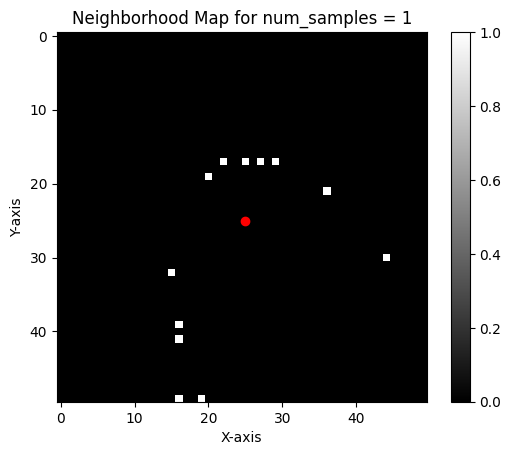

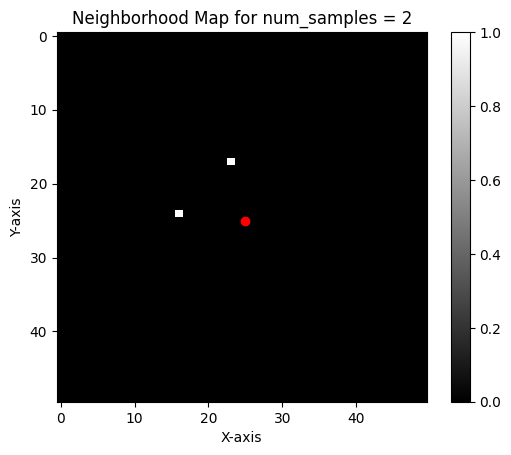

mip_positions shape = (2800, 2, 1)
candidate_positions shape = (2800, 1018, 4)
cand_pos shape = (2800, 1018, 2)
candidate_positions shape = (2800, 1018, 4)
extended_mip_positions shape = (2800, 1018, 2)
candidate_positions shape = (2800, 1018, 4)


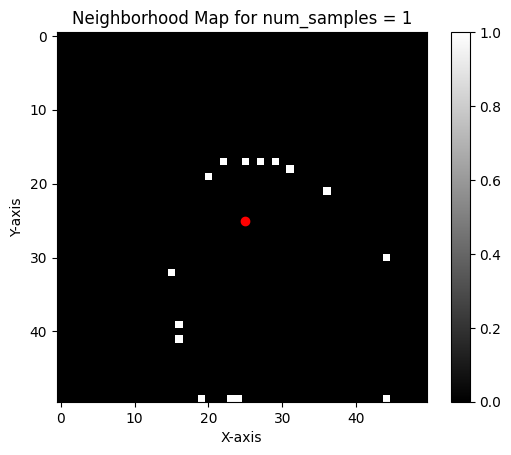

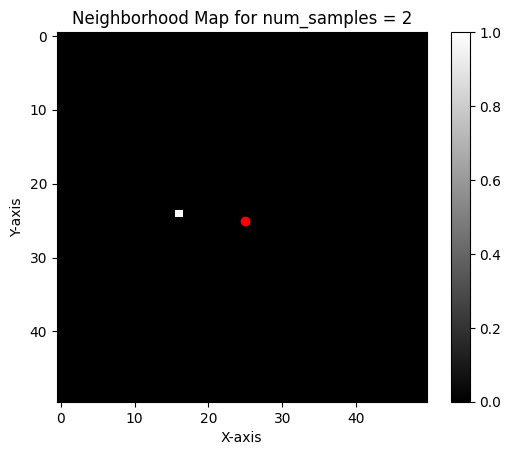

mip_positions shape = (2800, 2, 1)
candidate_positions shape = (2800, 1018, 4)
cand_pos shape = (2800, 1018, 2)
candidate_positions shape = (2800, 1018, 4)
extended_mip_positions shape = (2800, 1018, 2)
candidate_positions shape = (2800, 1018, 4)


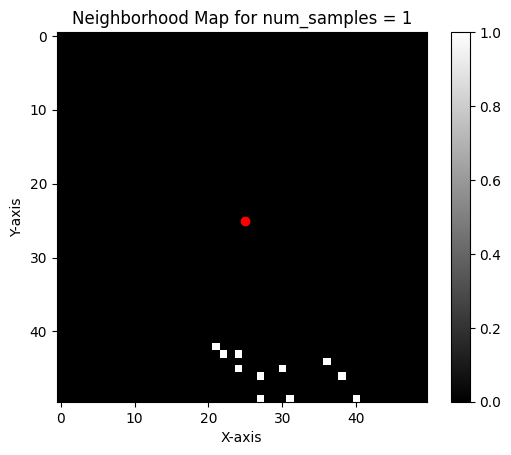

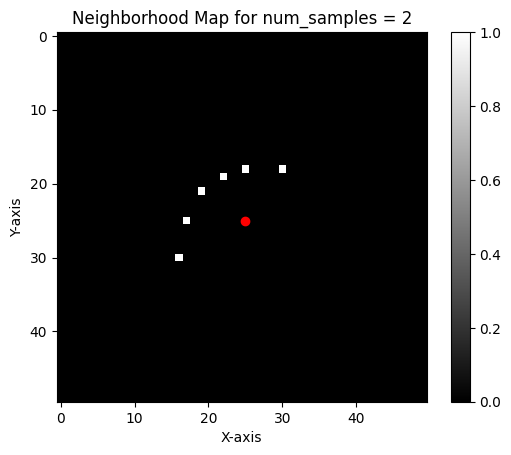

X_map_pion shape: (2800, 50, 50)
X_map_kaon shape: (2800, 50, 50)
X_map_proton shape: (2800, 50, 50)
  return (X_train, X_test, y_train, y_test) 
:


In [11]:

mask = [1,1,1,1]
X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test = classifier.preprocess_data()


# Plotting histograms of Training Versus Test Sets

In [12]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions.py
from misc_helper_functions import *

--2023-09-26 21:14:34--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-09-26 21:14:35 ERROR 404: Not Found.



In [13]:
# print("===== Evaluating Training Data =====")
# for feature, data in X_train.items():
#     print(f"Evaluating feature: {feature}")
#     eval_data(np.array(data))  # Assuming your function is designed to work with numpy arrays
#     print("---------------------------")

# # Loop through test_data dictionary
# print("===== Evaluating Test Data =====")
# for feature, data in X_test.items():
#     print(f"Evaluating feature: {feature}")
#     eval_data(np.array(data))  # Assuming your function is designed to work with numpy arrays
#     print("---------------------------")

In [14]:
# plot_hist(X_train=X_train, X_test=X_test, description = "Unscaled")


# Plot samples

In [15]:

X_train_pion_candidates = X_train["X_train_pion_candidates"]
X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
X_train_proton_candidates = X_train["X_train_proton_candidates"]
X_train_non_candidates = X_train["X_train_non_candidates"]
X_train_non_candidates = X_train["X_train_non_candidates"]

X_train_momentum = X_train["X_train_momentum"]
X_train_refractive_index = X_train["X_train_refractive_index"]
X_train_phi = X_train["X_train_phi"]
X_train_theta = X_train["X_train_theta"]

X_train_mip_position = X_train["X_train_mip_position"]
X_train_rad_position = X_train["X_train_rad_position"]


X_test_non_candidates = X_test["X_test_non_candidates"]

X_test_pion_candidates = X_test["X_test_pion_candidates"]
X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
X_test_proton_candidates = X_test["X_test_proton_candidates"]
X_test_momentum = X_test["X_test_momentum"]
X_test_refractive_index = X_test["X_test_refractive_index"]
X_test_phi = X_test["X_test_phi"]
X_test_theta = X_test["X_test_theta"]
X_test_mip_position = X_test["X_test_mip_position"]
X_test_rad_position = X_test["X_test_rad_position"]

below_zero_indexes = np.where(X_train_phi < 0)[0]
n = 10
first_n_below_zero_indexes = below_zero_indexes[:n]

print(first_n_below_zero_indexes)
#ef : TODO fix this again


[ 101  153  267  313  407  528  623  890  977 1100]


# PDG of train vs test

shape : y_test (560, 3)
shape : y_train (2240, 3)


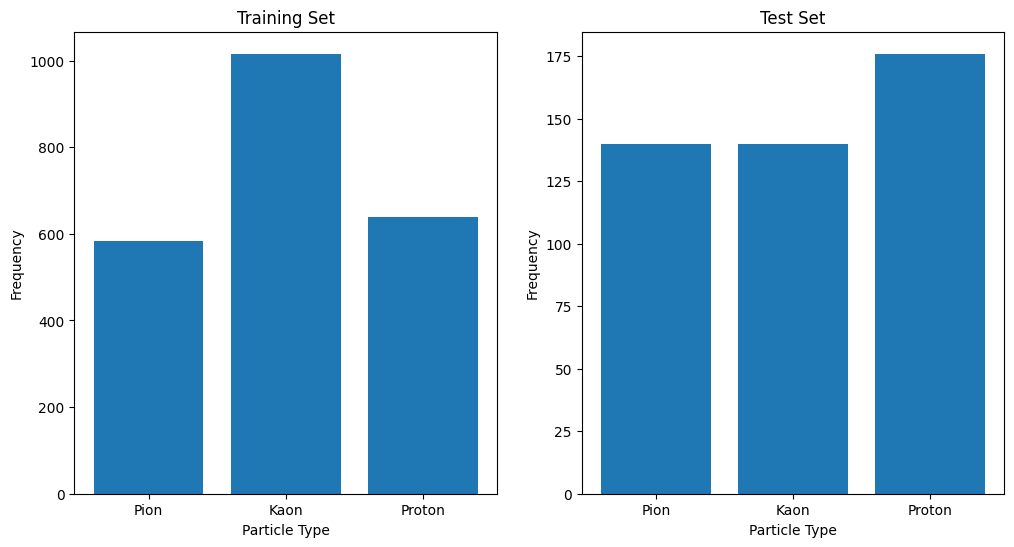

In [16]:
import matplotlib.pyplot as plt
import numpy as np


# for i in range(1,5):
#   print(y_test[i])



# # Counting occurrences in the training set



print(f"shape : y_test {y_test.shape}")
print(f"shape : y_train {y_train.shape}")




train_pion_count = np.sum(y_train[:, 0])
train_kaon_count = np.sum(y_train[:, 1])
train_proton_count = np.sum(y_train[:, 2])

# # Counting occurrences in the test set
test_pion_count = np.sum(y_test[:, 0])
test_kaon_count = np.sum(y_test[:, 0])
test_proton_count = np.sum(y_test[:, 2])

# print(f'Train : pion_count {train_pion_count}  kaon_count {train_kaon_count} proton_count {train_proton_count}')
# print(f'Test : pion_count {test_pion_count}  kaon_count {test_kaon_count} proton_count {test_proton_count}')

# # Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # Training set histogram
axs[0].bar(['Pion', 'Kaon', 'Proton'], [train_pion_count, train_kaon_count, train_proton_count])
axs[0].set_title('Training Set')
axs[0].set_xlabel('Particle Type')
axs[0].set_ylabel('Frequency')

# # Test set histogram
axs[1].bar(['Pion', 'Kaon', 'Proton'], [test_pion_count, test_kaon_count, test_proton_count])
axs[1].set_title('Test Set')
axs[1].set_xlabel('Particle Type')
axs[1].set_ylabel('Frequency')

plt.show()


In [17]:
#plot_first_instance(1, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates,\
#                    X_train_non_candidates,X_train_mCluSize, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta, y_train)



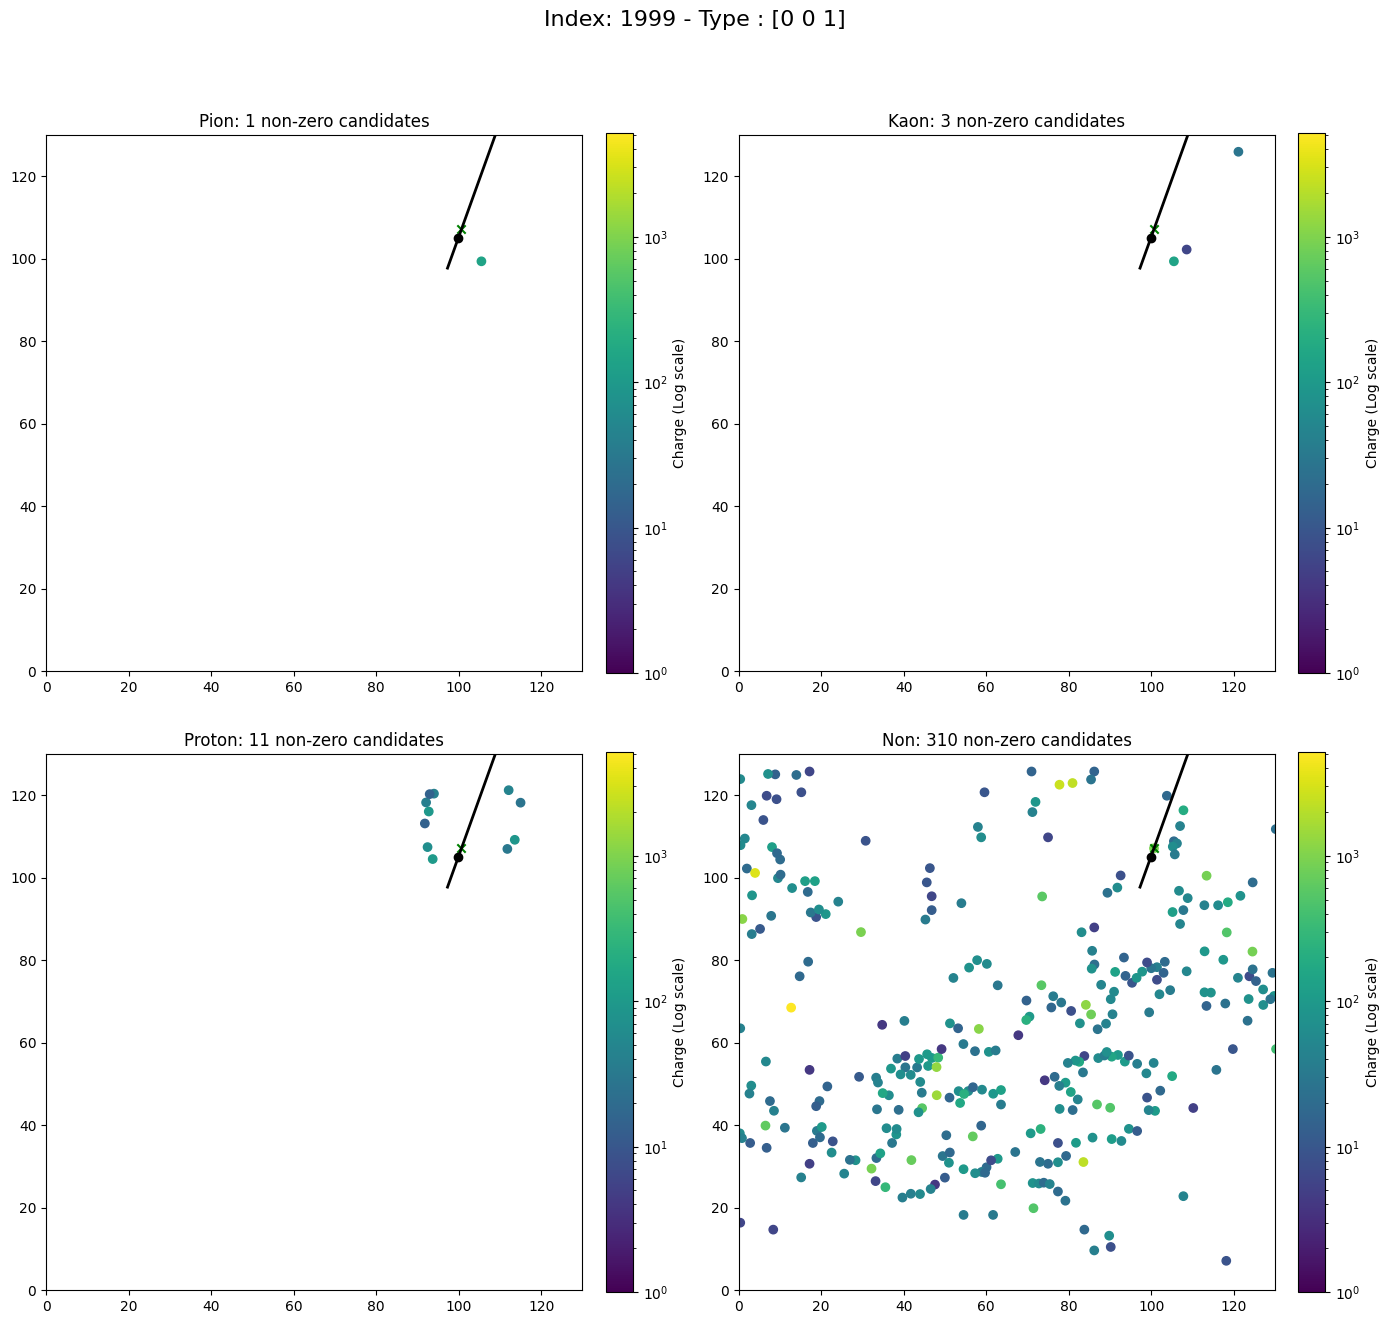

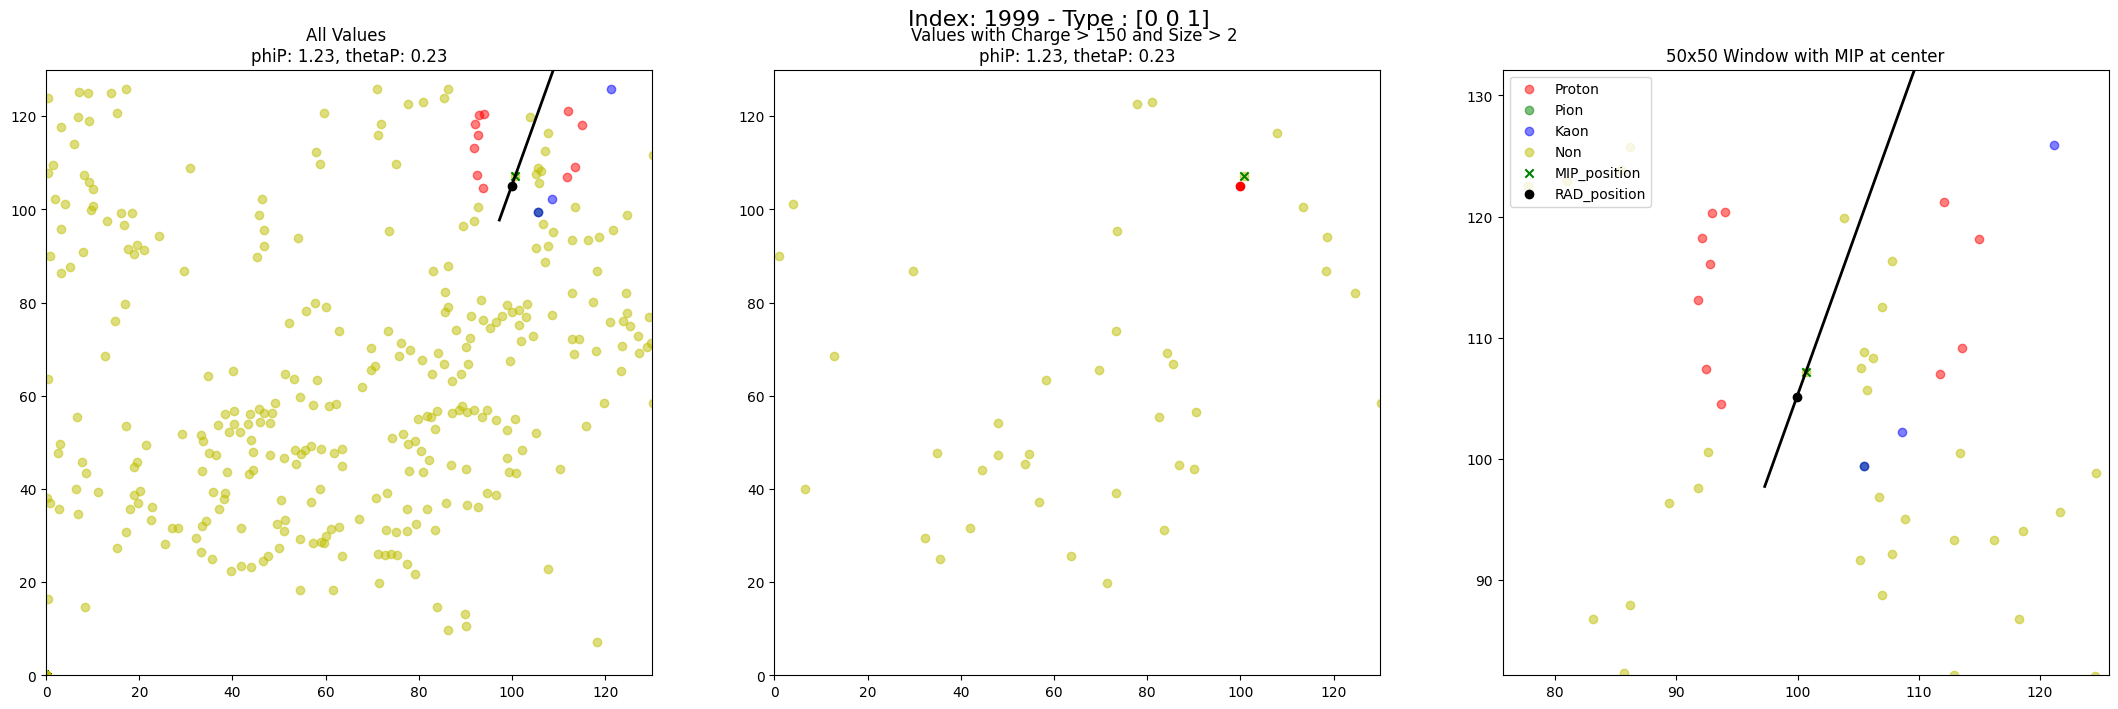

In [18]:
#plot_combined_types(1, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates)
# plot_individual_types(5, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates)

X_train_index_particle = X_train["X_train_index_particle"]
X_test_index_particle = X_test["X_test_index_particle"]

index = 2
X_train_mCluCharge = X_train["X_train_mCluCharge"]
X_train_mCluSize = X_train["X_train_mCluSize"]
X_test_mCluCharge = X_test["X_test_mCluCharge"]
X_test_mCluSize = X_test["X_test_mCluSize"]

#print(f"X_test_mCluCharge shape {X_test_mCluCharge[1]}")

#print(f"X_test_rad_position  {X_test_rad_position[0,:,:]}")

#print(f"X_test_mip_position  {X_test_mip_position[0,:,:]}")

#def plot_individual_types(idx, x_pion, x_kaon, x_proton, x_non, MIP_charge, MIP_position, RAD_position, y_train, log_scale):


plot_individual_types(idx=index, x_pion=X_test_pion_candidates, x_kaon=X_test_kaon_candidates, x_proton=X_test_proton_candidates, x_non=X_test_non_candidates, MIP_charge=X_test_mCluCharge, MIP_position=X_test_mip_position, RAD_position=X_test_rad_position, phi=X_test_phi, y_train=y_test, log_scale=True, X_index=X_test_index_particle)


#def plot_combined_types(i, x_pion, x_kaon, x_proton, x_non, MIP_position, RAD_position, phiP, thetaP, y_train):
plot_combined_types(index, X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates,X_test_mip_position, X_test_rad_position, X_test_phi, X_test_theta, y_train = y_test, X_index = X_test_index_particle)


#plot_combined_types3(index, X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates,X_test_mip_position, X_test_rad_position, X_test_phi, X_test_theta, y_test)



# Training the model


In [19]:





!wget -O ParticleDataUtilsCp.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/ParticleDataUtils21.py
from ParticleDataUtilsCp import ParticleDataUtils, classify_candidates_with_pad_sequences

!wget -O misc_helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions2.py
from misc_helper_functions import build_species_layers, calculate_theta, filter_data, create_lr_scheduler,plot_lr, extract_neighborhood_map, create_cnn_model # plot_worst

!wget -O helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
!wget -O plot_helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions22.py



from plot_helper_functions import plot_hist, plot_training_history, plot_confusion_matrix


print(classify_candidates_with_pad_sequences)


--2023-09-26 21:14:38--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/ParticleDataUtils21.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-09-26 21:14:38 ERROR 404: Not Found.

--2023-09-26 21:14:38--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32069 (31K) [text/plain]
Saving to: ‘misc_helper_functions.py’

misc_helper_functio 100%[===================>]  31.32K  --.-KB/s    in 0.007s  

2023-09-26 21:14:38 (4.1

In [20]:
# plot_helper_functions.plot_hist(X_train=X_train, X_test=X_test, description = "Unscaled")


In [ ]:
mask = [1,1,1,1]




fc1_unit = 64
units = [fc1_unit * i for i in [4, 2, 2, 1]]
units2 = [fc1_unit * i for i in [4, 2, 2, 1]]


final_concat_units = [16 * i for i in [64, 1]]

units = [fc1_unit * i for i in [128, 16, 8, 4, 2, 2, 1]]
units2 = [fc1_unit * i for i in [128, 16, 8,  4, 2, 2, 1]]

CNN_units =  [32, 8, 4, 2, 2, 1]
n_epochs = 50
model, history = classifier.train(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, mask = mask, num_epochs=n_epochs, include_cnn = False, units = units, units2 = units2, final_concat_units = final_concat_units, CNN_units = CNN_units)
#classifier.train(X_train = X_train_scaled, X_test = X_test_scaled, y_train = y_train, y_test = y_test, mask = mask, num_epochs=50)


Fields in the first vector of X_train:
X_train_pion_candidates shape: (2240, 1018, 4)
X_train_kaon_candidates shape: (2240, 1018, 4)
X_train_proton_candidates shape: (2240, 1018, 4)
X_train_momentum shape: (2240, 1)
X_train_refractive_index shape: (2240, 1)
X_train_phi shape: (2240, 1)
X_train_theta shape: (2240, 1)
X_train_mip_position shape: (2240, 2, 1)
X_train_rad_position shape: (2240, 2, 1)
X_train_map_pion shape: (2240, 50, 50, 1)
X_train_map_kaon shape: (2240, 50, 50, 1)
X_train_map_proton shape: (2240, 50, 50, 1)

Fields in the first vector of X_test:
X_test_pion_candidates shape: (560, 1018, 4)
X_test_kaon_candidates shape: (560, 1018, 4)
X_test_proton_candidates shape: (560, 1018, 4)
X_test_momentum shape: (560, 1)
X_test_refractive_index shape: (560, 1)
X_test_phi shape: (560, 1)
X_test_theta shape: (560, 1)
X_test_mip_position shape: (560, 2, 1)
X_test_rad_position shape: (560, 2, 1)
X_test_map_pion shape: (560, 50, 50, 1)
X_test_map_kaon shape: (560, 50, 50, 1)
X_test_map

/content/misc_helper_functions.py:427: RuntimeWarning: divide by zero encountered in double_scalars
  exp_decay = -np.log(end_lr / peak_lr) / (num_epochs - warmup_epochs)


now concat scalar 2D
now call extract_neighborhood_map
now concat_cnn done 
Concatenating layers by : concat = concatenate(concat_layers)
y_test.shape : (560, 3)
Epoch 1/50
35/35 [==============================] - 91s 749ms/step - loss: 836.6401 - accuracy: 0.3228 - val_loss: 836.5828 - val_accuracy: 0.2411 - lr: 0.0000e+00
Epoch 2/50
35/35 [==============================] - 22s 616ms/step - loss: 835.7675 - accuracy: 0.3156 - val_loss: 834.5934 - val_accuracy: 0.2411 - lr: 3.4014e-06
Epoch 3/50
35/35 [==============================] - 22s 634ms/step - loss: 832.9800 - accuracy: 0.3339 - val_loss: 830.8455 - val_accuracy: 0.3179 - lr: 6.8027e-06
Epoch 4/50
35/35 [==============================] - 22s 623ms/step - loss: 828.3381 - accuracy: 0.3888 - val_loss: 825.4249 - val_accuracy: 0.3232 - lr: 1.0204e-05
Epoch 5/50
35/35 [==============================] - 22s 628ms/step - loss: 821.9484 - accuracy: 0.4290 - val_loss: 818.1923 - val_accuracy: 0.3232 - lr: 1.3605e-05
Epoch 6/50
35/35 [

In [ ]:
X_train_pion_candidates = X_train["X_train_pion_candidates"]
X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
X_train_proton_candidates = X_train["X_train_proton_candidates"]

X_train_non_candidates = X_train["X_train_non_candidates"]
X_train_momentum = X_train["X_train_momentum"]
X_train_refractive_index = X_train["X_train_refractive_index"]
X_train_phi = X_train["X_train_phi"]
X_train_theta = X_train["X_train_theta"]
X_train_mip_position = X_train["X_train_mip_position"]
X_train_rad_position = X_train["X_train_rad_position"]
X_train_map_pion = X_train["X_train_map_pion"]
X_train_map_kaon = X_train["X_train_map_kaon"]
X_train_map_proton = X_train["X_train_map_proton"]






X_test_pion_candidates = X_test["X_test_pion_candidates"]
X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
X_test_proton_candidates = X_test["X_test_proton_candidates"]
X_test_non_candidates = X_test["X_test_non_candidates"]
X_test_momentum = X_test["X_test_momentum"]
X_test_refractive_index = X_test["X_test_refractive_index"]
X_test_phi = X_test["X_test_phi"]
X_test_theta = X_test["X_test_theta"]
X_test_mip_position = X_test["X_test_mip_position"]
X_test_rad_position = X_test["X_test_rad_position"]
X_test_map_pion = X_test["X_test_map_pion"]
X_test_map_kaon = X_test["X_test_map_kaon"]
X_test_map_proton = X_test["X_test_map_proton"]

X_train_mCluCharge = X_train["X_train_mCluCharge"]
X_train_mCluSize = X_train["X_train_mCluSize"]
X_test_mCluCharge = X_test["X_test_mCluCharge"]
X_test_mCluSize = X_test["X_test_mCluSize"]

In [ ]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import warnings
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, confusion_matrix

def plot_confusion_matrix(ax, cm, title="Confusion Matrix"):
    try:



        """Utility function to plot the confusion matrix."""
        ax.imshow(cm, cmap='Blues', interpolation='nearest')
        ax.set_xticks(np.arange(3))
        ax.set_yticks(np.arange(3))
        ax.set_xticklabels(['Pion', 'Kaon', 'Proton'])
        ax.set_yticklabels(['Pion', 'Kaon', 'Proton'])
        ax.set_title(title)
        for x in range(3):
            for y in range(3):
                percent = cm[x, y] / np.sum(cm[x, :]) * 100  # Percentage formula
                ax.text(y, x, f"{cm[x, y]} ({percent:.1f}%)", ha='center', va='center', color='red')

    except Exception as e:
        warnings.warn(f"Exception caught during plot_confusion_matrix : {e}")

def plot_training_history(history, y_pred_train, y_pred_test, y_train_true, y_test_true):
    try:
        fig2, axs2 = plt.subplots(1, 2, figsize=(25, 6))
        cm_train = confusion_matrix(y_train_true.argmax(axis=1), y_pred_train.argmax(axis=1))
        cm_test = confusion_matrix(y_test_true.argmax(axis=1), y_pred_test.argmax(axis=1))
        plot_confusion_matrix(axs2[0], cm_train, title="Train Confusion Matrix")
        plot_confusion_matrix(axs2[1], cm_test, title="Validation Confusion Matrix")
        plt.tight_layout()
        plt.show()

        fig, axs = plt.subplots(1, 2, figsize=(16, 18))
        axs[0].plot(history.history["loss"], label="Train Loss")
        axs[0].plot(history.history["val_loss"], label="Validation Loss")
        axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("Loss")
        axs[0].legend()

        axs[1].plot(history.history["accuracy"], label="Train Accuracy")
        axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Accuracy")
        axs[1].legend()
        class_labels = ['Pion', 'Kaon', 'Proton']

        fig, axs = plt.subplots(1, 2, figsize=(25, 6))
        y_train_bin = label_binarize(y_train_true, classes=['Pion', 'Kaon', 'Proton'])
        for i in range(3):
            precision_train, recall_train, _ = precision_recall_curve(y_train_bin[:, i], y_pred_train[:, i])
            axs[0].plot(recall_train, precision_train, lw=2, label=class_labels[i])
        axs[0].set_title("Train P-R Curve")
        axs[0].legend()

        y_test_bin = label_binarize(y_test_true, classes=['Pion', 'Kaon', 'Proton'])
        for i in range(3):
            precision_test, recall_test, _ = precision_recall_curve(y_test_bin[:, i], y_pred_test[:, i])
            axs[1].plot(recall_test, precision_test, lw=2, label=class_labels[i])
        axs[1].set_title("Validation P-R Curve")
        axs[1].legend()

    except Exception as e:
        warnings.warn(f"Exception caught during plot_training_history : {e}")


In [ ]:
import warnings

train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_momentum, X_train_refractive_index, X_train_phi, X_train_theta, X_train_mip_position, X_train_rad_position, X_train_mCluCharge, X_train_mCluSize]
test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_momentum, X_test_refractive_index, X_test_phi, X_test_theta, X_test_mip_position, X_test_rad_position, X_test_mCluCharge, X_test_mCluSize]

y_pred_train = model.predict(train_variables)
y_pred_test = model.predict(test_variables)
# First function call with 'self'
try:
    plot_training_history(history=history, y_pred_train=y_pred_train, y_pred_test=y_pred_test, y_train_true=y_train, y_test_true=y_test)
except Exception as e:
    warnings.warn(f"Exception caught during first function call: {e}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_histograms(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, y_train):
    labels = ['piontrack', 'kaontrack', 'protontrack']
    segments = ['pionsegm', 'kaonsegm', 'protonsegm']

    # Extract and store data
    data_matrix = {}
    for track in labels:
        data_matrix[track] = {}
        for segm in segments:
            data_matrix[track][segm] = {'charge': [], 'size': []}

    for idx, track in enumerate(labels):
        mask = np.all(y_train == np.eye(3)[idx], axis=1)

        data_matrix[track]['pionsegm']['charge'].extend(X_train_pion_candidates[mask, :, 3].ravel())
        data_matrix[track]['pionsegm']['size'].extend(X_train_pion_candidates[mask, :, 2].ravel())
        data_matrix[track]['kaonsegm']['charge'].extend(X_train_kaon_candidates[mask, :, 3].ravel())
        data_matrix[track]['kaonsegm']['size'].extend(X_train_kaon_candidates[mask, :, 2].ravel())
        data_matrix[track]['protonsegm']['charge'].extend(X_train_proton_candidates[mask, :, 3].ravel())
        data_matrix[track]['protonsegm']['size'].extend(X_train_proton_candidates[mask, :, 2].ravel())

    # Helper function to plot
    def generate_plot(filtered_charge=0, filtered_size=0, plot_type="all"):
        fig_hist, ax_hist = plt.subplots(3, 3, figsize=(15, 15))

        for i, track_type in enumerate(labels):
            for j, segm_type in enumerate(segments):
                charges = [c for c in data_matrix[track_type][segm_type]['charge'] if c > filtered_charge]
                sizes = [s for s in data_matrix[track_type][segm_type]['size'] if s > filtered_size]

                if plot_type == "charge":
                    ax_hist[i, j].set_yscale('log')
                    ax_hist[i, j].hist(charges, bins=125, range=(0, 250), edgecolor='black', alpha=0.6)
                    ax_hist[i, j].set_title(f"{track_type}, {segm_type} - Charge")

                elif plot_type == "size":
                    ax_hist[i, j].hist(sizes, bins=6, range=(0, 6), edgecolor='black', alpha=0.6)
                    ax_hist[i, j].set_yscale('log')
                    ax_hist[i, j].set_title(f"{track_type}, {segm_type} - Size")

                elif plot_type == "2d":
                    valid_charges = [c for idx, c in enumerate(data_matrix[track_type][segm_type]['charge']) if c > filtered_charge and data_matrix[track_type][segm_type]['size'][idx] > filtered_size]
                    valid_sizes = [s for idx, s in enumerate(data_matrix[track_type][segm_type]['size']) if data_matrix[track_type][segm_type]['charge'][idx] > filtered_charge and s > filtered_size]

                    hist = ax_hist[i, j].hist2d(valid_charges, valid_sizes, bins=(25, 6), range=[[0, 250], [0, 6]], cmin=1, norm=LogNorm())
                    plt.colorbar(hist[3], ax=ax_hist[i, j])
                    ax_hist[i, j].set_title(f"{track_type}, {segm_type} - 2D Charge vs Size")

        plt.tight_layout()
        plt.show()

    # Generate the plots
    generate_plot(plot_type="size")
    generate_plot(plot_type="charge")
    generate_plot(plot_type="2d")
    generate_plot(filtered_size=1, plot_type="size")
    generate_plot(filtered_charge=10, plot_type="charge")
    generate_plot(filtered_charge=10, filtered_size=1, plot_type="2d")



In [ ]:
plot_histograms(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, y_train)

In [ ]:

def freedman_diaconis_bins(data):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # Assuming data is 1D array
    data_range = np.nanmax(data) - np.nanmin(data)
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    bin_width = 2 * iqr * (len(data) ** -0.33)
    return int(data_range / bin_width) if bin_width > 0 else 1

def check_nan_inf(arr):
    """Check if array contains NaN or Inf values."""
    return np.isnan(arr).any(), np.isinf(arr).any()




def plot_hist(X_train=None, X_test=None, y_train = None, y_test = None, description=None):
    try:

        def plot_specialized_histograms(data, y_data, title):


          try:

              fig, axs = plt.subplots(3, 4, figsize=(25, 12))
              fig.suptitle(f"{title}", fontsize=20)

              # Separate data based on y-labels
              pion_indices = np.where(y_data == np.array([1, 0, 0]))[0]
              kaon_indices = np.where(y_data == np.array([0, 1, 0]))[0]
              proton_indices = np.where(y_data == np.array([0, 0, 1]))[0]
              print(y_data.shape)
              data_map = {
              'Pion': pion_indices,
              'Kaon': kaon_indices,
              'Proton': proton_indices
              }





              for idx, (particle, indices) in enumerate(data_map.items()):
                  clu_size = data['mCluSize'][indices]
                  clu_charge = data['mCluCharge'][indices]


                  clu_size = clu_size.reshape(-1)
                  clu_charge = clu_charge.reshape(-1)

                  print(f"np.any(np.isnan(clu_size)) {np.any(np.isnan(clu_size))}")

                  print(f"np.any(np.isnan(clu_charge)) {np.any(np.isnan(clu_charge))}")
                  print(f"np.any(np.isinf(clu_size)) {np.any(np.isinf(clu_size))}")
                  print(f"np.any(np.isinf(clu_charge)) {np.any(np.isinf(clu_charge))}")



                  print(f"len(clu_size) {len(clu_size)}")
                  print(f"len(clu_charge) {len(clu_charge)}")
                  print(f"pion_indices.shape {pion_indices.shape}")
                  print(f"kaon_indices.shape {kaon_indices.shape}")
                  print(f"proton_indices.shape {proton_indices.shape}")


                  # 1D histograms
                  axs[idx, 0].hist(clu_size, bins=9, range=(2, 11), edgecolor='black', alpha=0.6, label='MIP Cluster size')
                  axs[idx, 0].legend()
                  axs[idx, 0].set_title(f"{particle} MIP Cluster Size ")


                  # 1D histograms
                  axs[idx, 1].hist(clu_charge, bins=200, range=(0, 4000), edgecolor='black', alpha=0.6, label='MIP Cluster charge')
                  axs[idx, 1].legend()
                  axs[idx, 1].set_title(f"{particle} 'MIP Cluster charge")




                  try: # works!!

                      gridx = np.linspace(min(clu_size), max(clu_size),11)
                      gridy = np.linspace(min(clu_charge), max(clu_charge),200)
                      try:
                          h, xedges, yedges = np.histogram2d(clu_size, clu_charge, bins=[9, 30], range=[(2, 11), (200, 800)])
                      except ValueError as ve:
                          print("Error unpacking histogram2d results:", ve)
                          results = np.histogram2d(clu_size, clu_charge, bins=[gridx, gridy])
                          print("Results returned from histogram2d:", results)

                      norm = LogNorm()  # Define the logarithmic normalization
                      im = axs[idx, 2].pcolormesh(xedges, yedges, h.T, cmap='viridis', norm=norm)
                      axs[idx, 2].set_title(f"{particle} 2D Hist")
                      axs[idx, 2].set_xlabel("'MIP Cluster size")
                      axs[idx, 2].set_ylabel("'MIP Cluster charge")
                      #axs[idx, 2].set_yscale('log')

                      plt.colorbar(im, ax=axs[idx, 2])  # Add colorbar with logarithmic scale

                  except Exception as e:
                      warnings.warn(f"plot_specialized_histograms failed histogram2d : {e}")
                  try:
                      try:
                          h, xedges, yedges = np.histogram2d(clu_size, clu_charge, bins=[11, 200], range=[(0, 11), (0, 8000)])

                          ax_3d = axs[idx, 3]

                          ax_3d = fig.add_subplot(3, 4, 4 * idx + 4, projection='3d')  # change the layout
                          x_pos, y_pos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
                          x_pos = x_pos.flatten('F')
                          y_pos = y_pos.flatten('F')
                          z_pos = np.zeros_like(x_pos)
                          dx = dy = 0.5
                          dz = h.flatten()
                          ax_3d.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True)
                          ax_3d.set_title(f"{particle} 3D Bar Chart")
                          ax_3d.set_xlabel("mCluSize")
                          ax_3d.set_ylabel("mCluCharge")
                          ax_3d.set_zlabel("Counts")

                      except Exception as e:
                          warnings.warn(f"plot_specialized_histograms failed  np.histogram2 w : {e}")
                  except Exception as e:
                      warnings.warn(f"plot_specialized_histograms failed  # 3D View w : {e}")


              plt.tight_layout()
              plt.show()

          except Exception as e:
                warnings.warn(f"Exception caught during plot_specialized_histograms: {e}")


        # Call the new function to generate plots for training and testing datasets
        train_data = {
            'mCluSize': X_train["X_train_mCluSize"],
            "mCluCharge": X_train["X_train_mCluCharge"]
        }

        test_data = {
            'mCluSize': X_test["X_test_mCluSize"],
            "mCluCharge": X_test["X_test_mCluCharge"]
        }

        plot_specialized_histograms(train_data, y_train, title="Training Data")
        plot_specialized_histograms(test_data, y_test, title="Testing Data")


        fig, axs = plt.subplots(2, 4, figsize=(25, 10)) # For 'Refractive Index', 'Momentum', 'Phi', and 'Theta'
        fig.suptitle(f"Training and Testing Data: {description}", fontsize=20)

        fig_mClu, axs_mClu = plt.subplots(2, 2, figsize=(16, 10)) # For 'mCluSize' and 'mCluCharge'
        fig_mClu.suptitle(f"Cluster Features: {description}", fontsize=20)

        fig3, axs3 = plt.subplots(2, 5, figsize=(25, 10))
        fig3.suptitle(f"Training and Testing Data: {description}", fontsize=20)



        # impact points on rad / MIP spatial distribution
        fig1, axs1 = plt.subplots(2, 3, figsize=(18, 10))
        fig1.suptitle(f"2D Maps and Projections: {description}", fontsize=20)





        for key, value in X_train.items():
            print(key, type(value))





        def plot_routine(variables, row_idx):
            axs_idx = 0
            axs_idx = 0
            axs_mClu_idx = 0
            for label, variable in variables.items():
                has_nan, has_inf = check_nan_inf(variable)
                if has_nan or has_inf:
                    warnings.warn(f"{label} contains NaN or Inf values. This may lead to issues.")

                bins = freedman_diaconis_bins(variable)
                range_val = (np.nanmin(variable), np.nanmax(variable))

                if label == 'MIP Position' or label == 'Rad Position':
                    variable = np.asarray(variable).reshape(-1, 2)
                    mask = (variable[:, 0] != 0) & (variable[:, 1] != 0)
                    variable = variable[mask]
                    axs1[row_idx, 0].scatter(variable[:, 0], variable[:, 1], marker='o', s=10)
                    axs1[row_idx, 0].set_title(f"{'Train' if row_idx == 0 else 'Test'} 2D Map: {label}")
                    axs1[row_idx, 1].hist(variable[:, 0], bins=bins, range=range_val, edgecolor='black')
                    axs1[row_idx, 1].set_title(f"{label} X")
                    axs1[row_idx, 2].hist(variable[:, 1], bins=bins, range=range_val, edgecolor='black')
                    axs1[row_idx, 2].set_title(f"{label} Y")


                elif label == 'mCluSize':
                    axs_mClu[row_idx, axs_mClu_idx].hist(variable, bins=11, range=(0, 11), edgecolor='black')
                    axs_mClu[row_idx, axs_mClu_idx].set_title(f"{'Train' if row_idx == 0 else 'Test'} {label}")
                    axs_mClu_idx += 1

                elif label == 'mCluCharge':
                    axs_mClu[row_idx, axs_mClu_idx].hist(variable, bins=200, range=(0, 8000), edgecolor='black')
                    axs_mClu[row_idx, axs_mClu_idx].set_title(f"{'Train' if row_idx == 0 else 'Test'} {label}")
                    axs_mClu_idx += 1

                elif label == 'Momentum':
                    axs[row_idx, axs_idx].hist(variable, bins=50, range=(0, 5), edgecolor='black')
                    axs[row_idx, axs_idx].set_title(f"{'Train' if row_idx == 0 else 'Test'} {label}")
                    axs_idx += 1

                else:
                    axs[row_idx, axs_idx].hist(variable, bins=bins, range=range_val, edgecolor='black')
                    axs[row_idx, axs_idx].set_title(f"{'Train' if row_idx == 0 else 'Test'} {label}")
                    axs_idx += 1






        X_train_variables = {
        'Refractive Index': X_train["X_train_refractive_index"],
        'Momentum': X_train["X_train_momentum"],
        'Phi': X_train["X_train_phi"],
        'Theta': X_train["X_train_theta"],
        'mCluSize': X_train["X_train_mCluSize"],
        "mCluCharge": X_train["X_train_mCluCharge"],  # New addition
        'MIP Position': X_train["X_train_mip_position"],
        'Rad Position': X_train["X_train_rad_position"],
        'Pion Candidates': X_train["X_train_pion_candidates"],
        'Kaon Candidates': X_train["X_train_kaon_candidates"],
        'Proton Candidates': X_train["X_train_proton_candidates"]

        }


        # add kaon and proton candidates ;
        X_test_variables = {
        'Refractive Index': X_test["X_test_refractive_index"],
        'Momentum': X_test["X_test_momentum"],
        'Phi': X_test["X_test_phi"],
        'Theta': X_test["X_test_theta"],
        'mCluSize': X_test["X_test_mCluSize"],
        "mCluCharge": X_test["X_test_mCluCharge"],  # New addition
        'MIP Position': X_test["X_test_mip_position"],
        'Rad Position': X_test["X_test_rad_position"],
        'Pion Candidates': X_test["X_test_pion_candidates"],
        }

        train_data = {
        'mCluSize': X_train["X_train_mCluSize"],
        "mCluCharge": X_train["X_train_mCluCharge"]
        }

        test_data = {
        'mCluSize': X_test["X_test_mCluSize"],
        "mCluCharge": X_test["X_test_mCluCharge"]
        }



        plot_routine(X_train_variables, 0)
        plot_routine(X_test_variables, 1)

        plt.show()

    except Exception as e:
        warnings.warn(f"Exception caught during plot_histl: {e}")

import warnings

try:

    plot_hist(X_train = X_train, X_test =  X_test, y_train = y_train, y_test = y_test,  description = "unscaled")
except Exception as e:
    warnings.warn(f"Exception caught during first function call: {e}")




In [ ]:

import warnings

try:
    plot_hist(X_train = X_train, X_test =  X_test, y_train = y_train, y_test = y_test,  description = "unscaled")
except Exception as e:
    warnings.warn(f"Exception caught during first function call: {e}")




In [ ]:
threshold = 0.7

X_test = X_test
y_train = y_train
y_test = y_test
#X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test = classifier.preprocess_data()


train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_momentum, X_train_refractive_index, X_train_phi, X_train_theta, X_train_mip_position, X_train_rad_position, X_train_mCluCharge, X_train_mCluSize]
test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_momentum, X_test_refractive_index, X_test_phi, X_test_theta, X_test_mip_position, X_test_rad_position, X_test_mCluCharge, X_test_mCluSize]

y_pred_train = model.predict(train_variables)
y_pred_test = model.predict(test_variables)

plot_individual_types(idx=index, x_pion=X_test_pion_candidates, x_kaon=X_test_kaon_candidates, x_proton=X_test_proton_candidates, x_non=X_test_non_candidates, MIP_charge=X_test_mCluCharge, MIP_position=X_test_mip_position, RAD_position=X_test_rad_position, phi=X_test_phi, y_train=y_test, log_scale=True, X_index=X_test_index_particle)


#def plot_combined_types(i, x_pion, x_kaon, x_proton, x_non, MIP_position, RAD_position, phiP, thetaP, y_train):
#

class_labels  = ["pion", "kaon", "proton"]
i = 0
for pred, true in zip(y_pred_test, y_test):
    max_prob = np.max(pred)
    predicted_class = np.argmax(pred)
    if max_prob > threshold:
        label = class_labels[predicted_class]  # Assuming class_labels is a list of your labels
    else:
        label = 'reject'

    print(f"====================================================================================== \n")

    str = f" predicted_class = {predicted_class}  true class = {true}|  max_prob = {max_prob:.2f} pred = {pred}"

    plot_individual_types(idx=i, x_pion=X_test_pion_candidates, x_kaon=X_test_kaon_candidates, x_proton=X_test_proton_candidates, x_non=X_test_non_candidates, MIP_charge=X_test_mCluCharge, MIP_position=X_test_mip_position, RAD_position=X_test_rad_position, phi=X_test_phi, y_train=y_test, log_scale=True, X_index=X_test_index_particle)
    plot_combined_types(i, X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates,X_test_mip_position, X_test_rad_position, X_test_phi, X_test_theta, y_train = y_test, X_index = X_test_index_particle)
    print(str)
    i = i + 1

In [ ]:
mask = [1,1,1,1]




fc1_unit = 64
units = [fc1_unit * i for i in [64, 32, 16, 16, 8, 4, 4, 2, 2, 1]]
units2 = [fc1_unit * i for i in [64, 32, 16, 16, 8, 4, 4, 2, 2, 1]]

CNN_units = None

classifier.train(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, mask = mask, num_epochs=150, include_cnn = True, units = units, units2 = units2, CNN_units = CNN_units)
#classifier.train(X_train = X_train_scaled, X_test = X_test_scaled, y_train = y_train, y_test = y_test, mask = mask, num_epochs=50)

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
from helper_functions import *

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py
from plot_helper_functions import *

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py
from plot_helper_functions import *